In [1]:
import os
os.chdir('/pasteur/u/clcp/med-evidence')
import json
import re
from collections import defaultdict, Counter
import functools
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator, PercentFormatter
from tqdm import tqdm
from easydict import EasyDict as edict
from transformers import GPT2Tokenizer
import time
from Bio import Entrez
plt.style.use('seaborn-v0_8-deep')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

/pasteur/u/clcp/micromamba/envs/medev2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### input statistics

#### make the setupdf

In [57]:
dataset_name = "manual_250"
with open(f".experiments/q_gen/{dataset_name}-setup.json", 'r') as fh:
    dssetup = json.load(fh)

In [58]:
rows = []
for review_pmid, qs in dssetup.items():
    for q in qs:
        q['review_pmid'] = review_pmid
        rows.append(q)
setupdf = pd.DataFrame(rows)
setupdf.loc[setupdf.evidence_quality == '', 'evidence_quality'] = 'n/a'
setupdf

,question_id,question,answer,evidence_quality,fulltext_required,comment,relevant_sources,review_pmid
0,0,Is the long-term rate of overall lymphocyst fo...,no difference,high,no,,[17466514],28660687
1,1,Is the short-term rate of overall lymphocyst f...,no difference,moderate,no,,"[9190979, 12214830]",28660687
2,2,Is the rate of clinician impression of cogniti...,higher,high,no,,"[15534239, 21519001]",25734590
3,3,Is the rate of patient self-reported impressio...,uncertain effect,high,no,,"[15534239, 21519001]",25734590
4,4,Is the number of people with at least one neop...,higher,n/a,no,,"[12196768, 16527699, 21159889, 16767577]",27056645
...,...,...,...,...,...,...,...,...
245,245,"Is radiographic progression higher, lower, or ...",insufficient data,n/a,no,,"[16947627, 18625622, 19560810]",28282491
246,246,"Is patient function measured by HAQ higher, lo...",insufficient data,n/a,no,,"[16162882, 12115176, 24972708]",28282491
247,247,"Is radiographic progression higher, lower, or ...",insufficient data,n/a,no,,"[16162882, 12115176, 24972708]",28282491
248,248,"Is cancer risk higher, lower, or the same when...",insufficient data,n/a,no,,"[16162882, 12115176, 24972708]",28282491


In [59]:
if not 'sla' in setupdf.columns:
    SOURCE_AGREEMENT_PCT_BINS = ['0%', '1-49%', '50%', '51-99%', '100%']
    def bin_sla_pct(x):
        if x < 0.1:
            return "0%"
        elif x < 0.5:
            return "1-49%"
        elif x == 0.5:
            return "50%"
        elif x < 1:
            return "51-99%"
        else:
            return "100%"

    ### source-level agreement calcs
    with open('run-med-evidence/___res/deepseekV3_SLA.jsonl', 'r') as fh:
        sla_data = [json.loads(l) for l in fh]

    question_source_scores = defaultdict(dict)
    for out in sla_data:
        model_ans = out.get('parsed_answer')
        ans = model_ans.get('answer', "").lower() if isinstance(model_ans, dict) else "invalid"
        score = (out['gt_answer'].lower() in ans.lower())
        question_id, source_pmid = out['question_id'].split('-')
        question_source_scores[question_id][source_pmid] = score
    sla_data = {}
    sla_data_binned = {}
    for qid, src_lbls in question_source_scores.items():
        sla_pct = sum(src_lbls.values())/len(src_lbls.values())
        sla_data[int(qid)] = sla_pct
    sla_df = pd.Series(sla_data).to_frame(name='sla').reset_index(names='question_id')
    setupdf = setupdf.merge(sla_df, on='question_id')

In [60]:
if not 'context_tokens' in setupdf.columns:
    with open(f"run-med-evidence/datasets/manual_250-fulltext.jsonl", 'r') as fh:
        dset = [edict(json.loads(l)) for l in fh]
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    get_count = lambda s: len(tokenizer.encode(s, add_special_tokens=False, verbose=False))
    output_data = []
    for rd in tqdm(dset):
        sources = {s.article_id: s.content for s in rd.sources}
        for q in rd.question_data:
            full_text = '\n'.join(sources[pmid] for pmid in q.relevant_sources)
            output_data.append({
                'question_id': int(q.question_id),
                'context_tokens': get_count(full_text)
            })
    token_data = pd.DataFrame(output_data)
    setupdf = setupdf.merge(token_data, on='question_id')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:10<00:00,  6.38it/s]


#### meshterms

In [61]:
outpath = "___tmp/manual_250-reviews.xml"
if not os.path.exists(outpath):
    Entrez.email = "clcp@stanford.edu"
    pmids = setupdf.review_pmid.unique().tolist()
    with Entrez.efetch(db="pubmed", id=pmids, retmode="xml") as handle:
        res = handle.read()
    with open(outpath, 'wb') as fh:
        fh.write(res)
review_xml = Entrez.read(outpath)
        

In [ ]:
major = 'N'
meshterms = {}
for article_elem in review_xml['PubmedArticle']:
    pmid = str(article_elem['MedlineCitation']['PMID'])
    terms = []
    for mesh in article_elem['MedlineCitation'].get('MeshHeadingList', []):
        # grab the qualifier major/minor flag, if any
        qualifiers = mesh['QualifierName']
        # if len(qualifiers) > 0:
        #     major = str(qualifiers[0].attributes.items()[0][1])
        # grab descriptor name
        descr = mesh['DescriptorName']
        terms.append(descr.title())
    meshterms[pmid] = list(set(terms))
all_meshterms = set(functools.reduce(lambda x, y: x + y, meshterms.values()))
print('\n'.join(all_meshterms))

In [63]:
import sys
sys.path.append('run-med-evidence/src')
import queryllms
import concurrent.futures

In [64]:
# os.environ["VLLM_SERVER"] = "http://pasteur9.stanford.edu:8002/v1"
llm = queryllms.QueryLLM(provider="together", model="deepseek-ai/DeepSeek-R1-Distill-Llama-70B")

In [65]:
base_prompt = """
Consider the following categories:
1. Internal Medicine & Subspecialties
2. Surgery
3. Pediatrics & Neonatology
4. Obstetrics & Gynecology
5. Psychiatry & Neurology
6. Oncology & Hematology
7. Emergency Medicine & Critical Care
8. Family Medicine & Preventive Care
9. Dentistry & Oral Health
10. Public Health, Epidemiology & Health Systems
11. Other

Given the following QUESTION, categorize it into the best-fitting category.
Use the following output format:
**CATEGORY**: Surgery
**REASONING**: your reasoning for your selection

Think step by step.
QUESTION: {q}
"""

In [66]:
def parse(r):
    pattern = r"(-\s*)?\*\*(.*?)\*\*:\s*((.|\n)*?)(?=\n+(-\s*)?\*\*|\Z)"
    matches = re.findall(pattern, r , re.DOTALL) # Extract matches
    if matches:
        # Convert to a dictionary
        parsed_data = {}
        for (_,key,value,_,_) in matches:
            formatted_key = key.strip().lower().replace(" ","_")
            parsed_data[formatted_key] = value.strip()
        return parsed_data
    else:
        return {'unknown': r}

def ask(question_id, question):
    prompt = base_prompt.format(q=question)
    response = llm.simple_query('follow instruction', prompt)
    parsed = parse(response)
    return (question_id, parsed)

responses = []
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    futures = [executor.submit(ask, q.question_id, q.question) for _,q in setupdf.iterrows()]
    with tqdm(total=len(setupdf), desc="answering questions") as pbar:
        for future in concurrent.futures.as_completed(futures):
            responses.append(future.result())
            pbar.update()
print(responses[12])

answering questions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:37<00:00,  2.58it/s]

(0, {'category': 'Surgery', 'reasoning': 'The question focuses on comparing surgical drainage techniques (retroperitoneal drainage vs. no drainage) and their impact on lymphocyst formation, a post-surgical complication. This directly relates to surgical procedures and their outcomes, making Surgery the best-fitting category.'})


In [67]:
categorydata = []
for (qid, r) in responses:
    categorydata.append({
        'question_id': qid,
        'med_specialty': r['category']
    })
categorydf = pd.DataFrame(categorydata)
setupdf = setupdf.merge(categorydf, on='question_id')

In [74]:
setupdf.iloc[221, -1] = 'Emergency Medicine & Critical Care'

In [75]:
Counter(setupdf.med_specialty.values)

Counter({'Public Health, Epidemiology & Health Systems': 49,
         'Surgery': 44,
         'Psychiatry & Neurology': 39,
         'Pediatrics & Neonatology': 26,
         'Internal Medicine & Subspecialties': 23,
         'Emergency Medicine & Critical Care': 19,
         'Family Medicine & Preventive Care': 18,
         'Oncology & Hematology': 15,
         'Obstetrics & Gynecology': 12,
         'Dentistry & Oral Health': 3,
         'Other': 2})

In [81]:
setupdf.to_csv('run-med-evidence/___res/dataset_stats.csv', index=False)

#### add dates

In [258]:
import download_pubmed_data as dpd
data = dpd.get_review_pmid_data()

'38534000'

In [297]:
year_map = {}
for review_pmid in setupdf.review_pmid.unique():
    year = int(data[review_pmid]['date'][:4])
    year_map[review_pmid] = year
setupdf['review_year'] = setupdf.review_pmid.map(year_map)
setupdf.to_csv('run-med-evidence/___res/dataset_stats.csv', index=False)

#### plot stats

In [365]:
import ast
setupdf = pd.read_csv('run-med-evidence/___res/dataset_stats.csv')
setupdf.loc[:,'relevant_sources'] = setupdf['relevant_sources'].apply(ast.literal_eval)
setupdf['review_pmid'] = setupdf['review_pmid'].astype(str)
setupdf.loc[:, 'evidence_quality'] = setupdf['evidence_quality'].fillna('N/A')

In [372]:
setupdf['nsrc'] = [len(x) if len(x) < 4 else 4 for x in setupdf.relevant_sources]

In [374]:
setupdf.groupby(['nsrc', 'answer']).agg({'question_id':'count'})

question_id
nsrc answer                        
1    higher                      14
     insufficient data           18
     lower                       20
     no difference               43
     uncertain effect            20
2    higher                      12
     lower                       14
     no difference               18
     uncertain effect            13
3    higher                       4
     insufficient data           13
     lower                        8
     no difference               10
     uncertain effect             3
4    higher                      13
     insufficient data            7
     lower                        8
     no difference                8
     uncertain effect             4

In [96]:
a = []
for x in setupdf.relevant_sources.values:
    a += x
print(len(a))
print(len(set(a)))

558
270


In [194]:
def donut_plot(ax, data, labels, pal, **kwargs):
    wedges, texts, autotexts = ax.pie(data, wedgeprops=dict(width=0.6), colors=pal, autopct="%1.1f%%",
        labels=labels, #textprops={'bbox': dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)},
        pctdistance=0.7, explode=[0.03]*len(data), **kwargs)
    for i, a in enumerate(autotexts):
        a.set_bbox(None)
    return ax

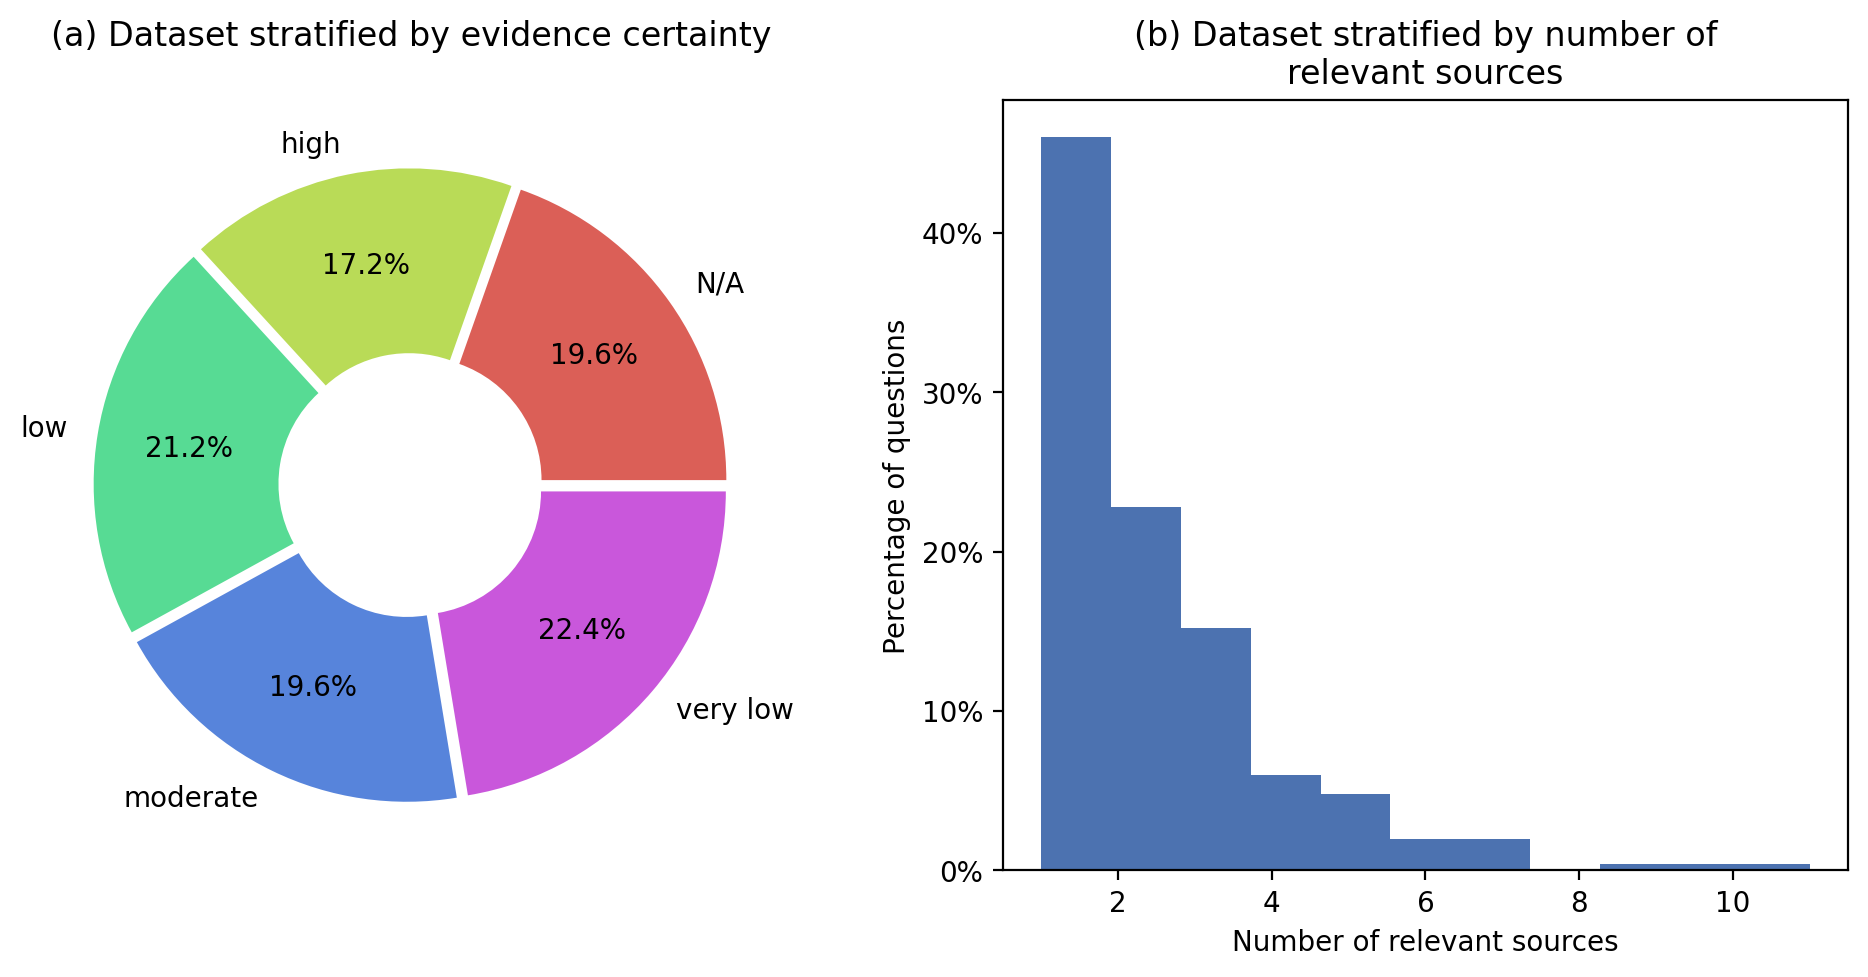

In [252]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5), dpi=200)
pal = sns.color_palette('hls', n_colors=5)
eq = setupdf.groupby('evidence_quality').agg({'question_id':'count'})
donut_plot(ax[0], data=eq.values.flatten(), labels=eq.index, pal=pal, startangle=0, labeldistance=1.1)
ax[0].set_title('(a) Dataset stratified by evidence certainty\n')
ax[1].hist([len(x) for x in setupdf.relevant_sources], bins=11, weights=np.ones(len(setupdf)) / len(setupdf))
ax[1].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax[1].set_title('(b) Dataset stratified by number of\nrelevant sources')
ax[1].set_xlabel('Number of relevant sources')
ax[1].set_ylabel('Percentage of questions')

fig.show()

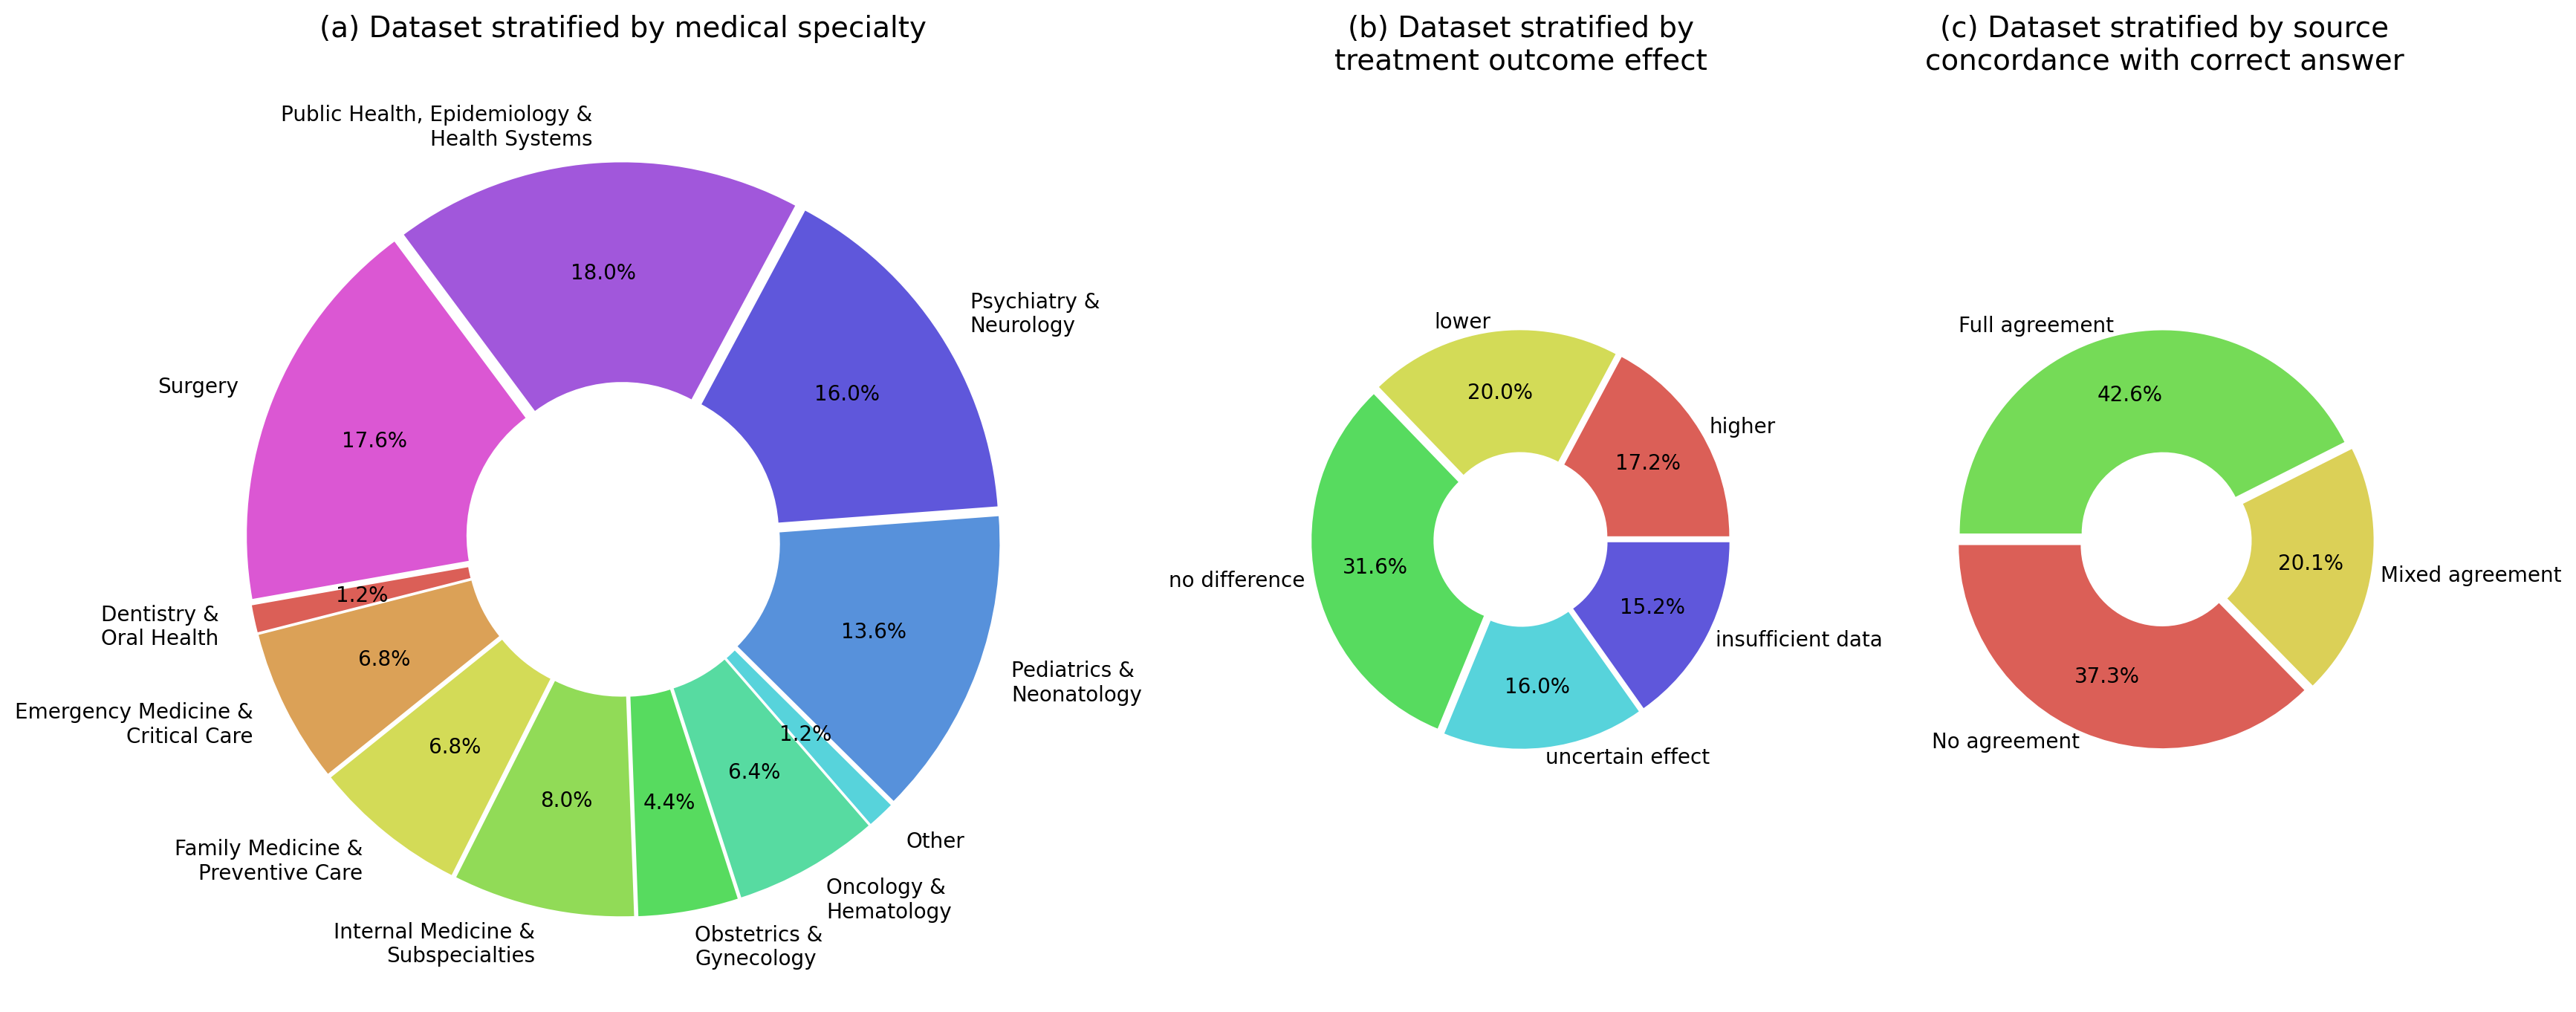

In [244]:
TITLE_SIZE = 14
pal = sns.color_palette('hls', n_colors=12)
fig, ax = plt.subplots(ncols=3, width_ratios=[2, 1, 1], figsize=(20,8), dpi=200)

setupdf['_med'] = setupdf['med_specialty'].str.replace('& ', '&\n')
med_distrib = setupdf.groupby('_med').agg({'question_id': 'count'})#.drop('Other')
donut_plot(ax[0], data=med_distrib.values.flatten(), labels=med_distrib.index, pal=pal, startangle=190, labeldistance=1.1)
ax[0].set_title('(a) Dataset stratified by medical specialty\n', fontsize=TITLE_SIZE)

label_distrib = setupdf.groupby('answer').agg({'question_id': 'count'})
pal = sns.color_palette('hls', n_colors=6)
label_distrib = label_distrib.loc[['higher', 'lower', 'no difference', 'uncertain effect', 'insufficient data']]
donut_plot(ax[1], data=label_distrib.values.flatten(), labels=label_distrib.index, pal=pal, labeldistance=1.05)
ax[1].set_title('(b) Dataset stratified by\ntreatment outcome effect', fontsize=TITLE_SIZE)

sla_bins = [(setupdf.sla.values < 0.1).sum(),
            ((setupdf.sla.values > 0.1) & (setupdf.sla.values < 0.99)).sum(),
            (setupdf.sla.values > 0.99).sum()]
pal = sns.color_palette('hls', n_colors=7)
sla_labels = ['No agreement', 'Mixed agreement', 'Full agreement']
donut_plot(ax[2], sla_bins, sla_labels, pal=pal, labeldistance=1.05, startangle=180)
ax[2].set_title('(c) Dataset stratified by source\nconcordance with correct answer', fontsize=TITLE_SIZE)

fig.align_titles()
# fig.suptitle('Question distributions\n', fontsize=TITLE_SIZE+5)

# ax[2].tick_params(axis='x', labelrotation=30)
fig.show()

### outputs

In [44]:
review_data = dpd.get_review_pmid_data()

for rev in review_data:
    title_len = len(review_data[rev]['title'])
    if title_len < 10:
        print(rev)

27605387


In [2]:
ANSWER_CLASSES = ["higher", "lower", "no difference", "insufficient data", "uncertain effect"]
DEFAULT_ANS = "invalid"

In [55]:
def dump(filepath, question_ids):
    with open(filepath, 'r') as fh:
        outputs = [json.loads(line) for line in fh]
    outputs = sorted(outputs, key=lambda o: o['question_id'])
    str_outputs = []
    for out in outputs:
        if not (out['question_id'] in question_ids):
            continue
        used_articles = [a['article_id'] for a in out["articles"]]
        str_out = f"""EXAMPLE {out['question_id']} [REVIEW_PMID = {out['original_review']}]\n""" \
                + f"""QUESTION: {out['gt_question']}\nRESPONSE:\n{out['answer']}\n""" \
                + f"""GT ANSWER: {out['gt_answer']}\nPMIDS OF SOURCES USED: {used_articles}\n\nREASON:"""
        str_outputs.append(str_out)
    with open('___tmp/dump.txt', 'w') as fh:
        fh.write(f'\n\n{"-"*10}\n\n'.join(str_outputs))
    print('dumped')

In [56]:
dump('run-med-evidence/___res/deepseekV3_closed_barebones_fulltext.jsonl', eval_df.question_id[~eval_df.score].values)

dumped


In [49]:
eval_df = grade('run-med-evidence/___res/deepseekV3_closed_barebones_fulltext.jsonl')


array([219,   6,   1,   8,  14,  23,  12,  17,  18,  33,  43,  32,  44,
        45,  27,  47,  30,  46,  55,  54,  48,  50,  56,  64,  62,  57,
        65,  63,  74,  72,  75,  71,  78,  87,  82,  90,  77,  88,  86,
        92,  91, 105,  98, 102, 104, 230, 112, 106, 116, 113, 114, 117,
       119, 131, 134, 141, 143, 140, 144, 142, 152, 156, 155, 162, 163,
       178, 172, 176, 177, 183, 182, 175, 186, 189, 196, 192, 195, 197,
       198, 193, 204, 201, 205, 200, 208, 206, 207, 213, 211, 218, 216,
       210, 246, 212])

In [27]:
files = [
    ("run-med-evidence/___res/manual101ft_qwen32b_closed_basic.jsonl", 'qwen_basic'),
    ("run-med-evidence/___res/manual101ft_qwen32b_closed_qualAware.jsonl", 'qwen_aware'),
    ("run-med-evidence/___res/manual101ft_qwen32b_closed_qualPrio.jsonl", 'qwen_priority'),
    ("run-med-evidence/___res/manual101ft_qwen32b_closed_cochraneAware.jsonl", 'qwen_cochrane'),
    ("run-med-evidence/___res/manual101ft_qwen32b_filterClosed_qualAware.jsonl", 'qwen_noisyclosed'),
    ("run-med-evidence/___res/manual101abs_qwen32b_closed_qualAware.jsonl", 'qwen_abstract'),
    # ("run-med-evidence/___res/manual101abs_llamaR1_closed_basic.jsonl", 'r1_abstract'),
    # ("run-med-evidence/___res/manual101ft_llamaR1_closed_qualAware.jsonl", 'r1_aware'),
    # ("run-med-evidence/___res/manual101ft_llamaR1_closed_qualPrio.jsonl", 'r1_priority'),
    # ("run-med-evidence/___res/manual101ft_llamaR1_filterClosed_basic.jsonl", 'r1_noisyclosed'),
    # ("run-med-evidence/___res/manual101ft_llamaR1_closed_basic.jsonl", 'r1_basic')
]
groupby_key = "evidence_quality"
# joint_key = "score"
# joint_basecols = ["question_id", "review_id", "question", "fulltext_required", "correct_answer"]
joint_df = pd.DataFrame()
for (filepath, shortname) in files:
    print("\n\n"+shortname)
    eval_df = grade(filepath)
    # print(eval_df.score.mean())
    if joint_df.empty:
        joint_df = eval_df[joint_basecols]
    _subset = eval_df[["question_id", joint_key]].rename(columns={joint_key: shortname})
    joint_df = joint_df.merge(_subset, how='outer', on=["question_id"])
    grouped_df = eval_df.groupby(groupby_key).agg(
        accuracy=pd.NamedAgg(column="score", aggfunc="mean"),
        n_correct=pd.NamedAgg(column="score", aggfunc="sum"),
        n_questions=pd.NamedAgg(column="question", aggfunc="count")
    ).astype({"n_correct": int, "n_questions": int}).sort_values("accuracy")
    display(grouped_df.loc[['', 'very low', 'low', 'moderate', 'high']])
    # conf_mat_data = []
    # all_classes = ANSWER_CLASSES + ['invalid']
    # for p_label in all_classes:
    #     row = []
    #     p_label_mask = eval_df.pred_answer.str.lower() == p_label
    #     for c_label in all_classes:
    #         c_label_mask = eval_df.correct_answer.str.lower() == c_label
    #         row.append((c_label_mask & p_label_mask).sum())
    #     conf_mat_data.append(row)
    # conf_mat = pd.DataFrame(conf_mat_data,
    #                         columns=[["correct_answer"]*len(all_classes), all_classes],
    #                         index=[["pred_answer"]*len(all_classes), all_classes],
    # )
    # display(conf_mat)

In [14]:
joint_df.groupby('fulltext_required').mean(numeric_only = True)

,question_id,qwen_basic,qwen_aware,qwen_priority,qwen_cochrane,qwen_noisyclosed,qwen_abstract
fulltext_required,,,,,,,
no,46.683544,0.582278,0.582278,0.531646,0.582278,0.544304,0.569620
yes,61.909091,0.681818,0.590909,0.545455,0.727273,0.545455,0.636364


In [25]:
fulltext_ids = joint_df.question_id[joint_df.fulltext_required == 'yes'].to_list()
dump('run-med-evidence/___res/manual101ft_qwen32b_closed_cochraneAware.jsonl', fulltext_ids)

dumped


In [ ]:
eval_df[eval_df.fulltext_required == 'yes']

In [51]:
joint_scores = joint_df[joint_basecols].copy()
for (_, shortname) in files:
    joint_scores.loc[:, shortname] = (joint_df[shortname] == joint_df.correct_answer)
all_wrong = (~joint_scores.iloc[:,4:]).all(axis=1)
all_wrong.mean()

np.float64(0.21782178217821782)

In [ ]:
joint_df[all_wrong]#.groupby('correct_answer').agg({'question_id':'count'})

In [ ]:
joint_df[all_wrong].question.to_list()

In [ ]:
joint_df["diff"] = joint_df.default != joint_df.abstract

### final figure plots

#### define funcs

In [3]:

import ast
setupdf = pd.read_csv('run-med-evidence/___res/dataset_stats.csv').drop(columns=['question', 'answer'])
setupdf.loc[:,'relevant_sources'] = setupdf['relevant_sources'].apply(ast.literal_eval)
setupdf['review_pmid'] = setupdf['review_pmid'].astype(str)
setupdf.loc[:, 'evidence_quality'] = setupdf['evidence_quality'].fillna('N/A')
setup_dict = setupdf.set_index('question_id').T.to_dict()
setupdf


,question_id,evidence_quality,fulltext_required,comment,relevant_sources,review_pmid,sla,context_tokens,med_specialty,review_year
0,0,high,no,NaN,[17466514],28660687,1.000000,287,Surgery,2017
1,1,moderate,no,NaN,"[9190979, 12214830]",28660687,0.500000,608,Surgery,2017
2,2,high,no,NaN,"[15534239, 21519001]",25734590,0.500000,669,Psychiatry & Neurology,2015
3,3,high,no,NaN,"[15534239, 21519001]",25734590,0.000000,669,Psychiatry & Neurology,2015
4,4,N/A,no,NaN,"[12196768, 16527699, 21159889, 16767577]",27056645,0.250000,1610,Internal Medicine & Subspecialties,2016
...,...,...,...,...,...,...,...,...,...,...
245,245,N/A,no,NaN,"[16947627, 18625622, 19560810]",28282491,1.000000,13073,Internal Medicine & Subspecialties,2017
246,246,N/A,no,NaN,"[16162882, 12115176, 24972708]",28282491,0.666667,1307,Internal Medicine & Subspecialties,2017
247,247,N/A,no,NaN,"[16162882, 12115176, 24972708]",28282491,1.000000,1307,Internal Medicine & Subspecialties,2017
248,248,N/A,no,NaN,"[16162882, 12115176, 24972708]",28282491,1.000000,1307,Oncology & Hematology,2017


In [4]:
def bin_n_source(n):
    if n < 4:
        return str(n)
    else:
        return "4+"

def bin_sla_pct(x):
    if x < 0.1:
        return "0%"
    elif x < 0.5:
        return "1-49%"
    elif x == 0.5:
        return "50%"
    elif x < 1:
        return "51-99%"
    else:
        return "100%"

NSOURCE_BINS = ["1", "2", '3', "4+"]
ANSWER_CLASSES = ["higher", "lower", "no difference", "insufficient data", "uncertain effect"]
EVIDENCE_QUALITIES = ["very low", "low", "moderate", "high"]
DEFAULT_ANS = "invalid"
SOURCE_AGREEMENT_PCT_BINS = ['0%', '1-49%', '50%', '51-99%', '100%']

def grade(filepath):
    with open(filepath, 'r') as fh:
        outputs = [json.loads(line) for line in fh]
    eval_data = []
    
    for out in outputs:
        qid = out['question_id']
        setup = setup_dict[qid]
        model_ans = out.get('parsed_answer')
        ans = model_ans.get('answer', "").lower().strip() if isinstance(model_ans, dict) else ""
        # for ac in ANSWER_CLASSES:
        #     if ans.startswith(ac):
        #         ans = ac
        #         break
        score = (out['gt_answer'].lower() == ans)
        n_src_bin = bin_n_source(len(out['gt_relevant_sources']))
        sla_bin = bin_sla_pct(setup['sla'])
        eval_data.append({
            "question_id": qid,
            "review_id": out['original_review'],
            "question": out['question'],
            "score": score,
            "pred_answer": ans,
            "correct_answer": out['gt_answer'],
            "evidence_quality": out['gt_evidence_quality'],
            "review_pmid": out['original_review'],
            "n_sources": n_src_bin, # "no" if out['gt_answer'] == 'insufficient data' else 
            "fulltext_required": out['gt_fulltext_required'],
            "pred_reasoning": model_ans,
            "sla_bin": sla_bin,
            "review_year": setup['review_year']
        })
    eval_df = pd.DataFrame(eval_data)
    eval_df.loc[:, 'evidence_quality'] = eval_df.evidence_quality.replace('', "n/a")
    eval_df.loc[~eval_df.pred_answer.str.lower().isin(ANSWER_CLASSES), 'pred_answer'] = DEFAULT_ANS
    return eval_df

In [5]:
def make_df(basepath, output_files):
    data = []
    for (modelname, display_name, model_series, is_reasoning, model_size, is_medical) in output_files:
        filepath = basepath.format(MODEL=modelname)
        eval_df = grade(filepath)
        row = {
            "Model": display_name,
            "Reason Type": "Reasoning" if is_reasoning else "Non-Reasoning",
            "is_medical": is_medical,
            "Model Size": model_size if model_size > 0 else None,
            "Model Series": model_series or display_name,
            "Accuracy": eval_df.score.mean()
        }
        
        evlevel_df = eval_df.groupby("evidence_quality").agg(
            accuracy=pd.NamedAgg(column="score", aggfunc="mean"),
            n_correct=pd.NamedAgg(column="score", aggfunc="sum"),
            n_questions=pd.NamedAgg(column="question", aggfunc="count")
        ).sort_values("accuracy").astype({"n_correct": int, "n_questions": int})
        for evq in EVIDENCE_QUALITIES:
            row[evq] = evlevel_df.loc[evq, "accuracy"]
        
        correct_df = eval_df.groupby("correct_answer").agg(
            accuracy=pd.NamedAgg(column="score", aggfunc="mean"),
            n_correct=pd.NamedAgg(column="score", aggfunc="sum"),
            n_questions=pd.NamedAgg(column="question", aggfunc="count")
        ).sort_values("accuracy").astype({"n_correct": int, "n_questions": int})
        for cor_ans in ANSWER_CLASSES:
            row[cor_ans] = correct_df.loc[cor_ans, "accuracy"]
        
        preds = (eval_df.groupby("pred_answer").agg({"question": "count"}) / len(eval_df))['question'].to_dict()
        row['valid'] = 1 - preds.get('invalid', 0)
        
        nsrc_df = eval_df.groupby("n_sources").agg(
            accuracy=pd.NamedAgg(column="score", aggfunc="mean"),
            n_correct=pd.NamedAgg(column="score", aggfunc="sum"),
            n_questions=pd.NamedAgg(column="question", aggfunc="count")
        ).sort_values("accuracy").astype({"n_correct": int, "n_questions": int})
        for nbin in NSOURCE_BINS:
            row[nbin] = nsrc_df.loc[nbin, "accuracy"]
        
        sla_df = eval_df.groupby("sla_bin").agg(
            accuracy=pd.NamedAgg(column="score", aggfunc="mean"),
            n_correct=pd.NamedAgg(column="score", aggfunc="sum"),
            n_questions=pd.NamedAgg(column="question", aggfunc="count")
        ).sort_values("accuracy").astype({"n_correct": int, "n_questions": int})
        for sla_bin in SOURCE_AGREEMENT_PCT_BINS:
            row[sla_bin] = sla_df.loc[sla_bin, "accuracy"]
        
        data.append(row)

    df = pd.DataFrame(data).sort_values(['Accuracy', 'Model'])
    palette = sns.color_palette("Spectral", n_colors=len(df))
    return df, palette

In [6]:
def make_long_df(basepath, outfiles):
    dfs = []
    for (modelname, display_name, model_series, is_reasoning, model_size, is_medical) in outfiles:
        filepath = basepath.format(MODEL=modelname)
        eval_df = grade(filepath)
        eval_df["Model"] = display_name
        eval_df["Reason Type"] = "Reasoning" if is_reasoning else "Non-Reasoning"
        eval_df['is_medical'] = is_medical
        eval_df["Model Size"] = model_size if model_size > 0 else None
        eval_df["Model Series"] = model_series or display_name
        acc = eval_df.score.mean()
        eval_df["Accuracy"] = acc
        dfs.append(eval_df)
    long_df = pd.concat(dfs).sort_values(['Accuracy', 'Model'])
    model_order = long_df[long_df['question_id'] == 0][['Model', 'is_medical', 'Reason Type']].reset_index(drop=True)
    palette = sns.color_palette("Spectral", n_colors=len(model_order))
    _df_2 = long_df.copy(deep=True)
    _df_2["Model"] = "Average"
    _df_2["is_medical"] = 0
    _df_2["Reason Type"] = "Average"
    catdf = pd.concat([long_df, _df_2])
    avg_palette = palette + ['black']
    return long_df, palette, model_order, catdf, avg_palette

In [7]:
def pub_year_acc(ax, _df, pal):
    sns.lineplot(_df, x='review_year', y='score', hue='Model', style='Reason Type', palette=pal, 
                ax=ax, errorbar=None, markers='.', markersize=10)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.8), ncol=3)
    ax.set_xlabel('Systematic Review Publication Year')
    ax.set_ylabel('Accuracy')

In [8]:
def percent_valid_plot(ax, df, pal):
    # percent valid
    sns.barplot(df, x='valid', y='Model', hue='Model', orient='h', ax=ax, palette=pal)
    for i, bar in enumerate(ax.patches):
        if df.iloc[i].is_medical:
            bar.set_edgecolor('black')
            bar.set_linewidth(2)
        if df.iloc[i]['Reason Type'] == 'Reasoning':
            bar.set_hatch('//')
    legend_elements = [
        Patch(facecolor='grey', hatch='//', label=f'Reasoning'),
        Patch(facecolor='grey', hatch='', label=f'Non-Reasoning'),
        Patch(facecolor='grey', edgecolor='black', linewidth=2, hatch='', label=f'Medically Finetuned')
    ]
    ax.set_xlim(0, 1)
    ax.set_ylabel('')
    ax.set_xlabel('Percentage Parsable Outputs')

    ax.legend(handles=legend_elements)

In [22]:
def evidence_quality_plot(ax, df, pal):
    # by evidence quality
    # evqual_df = df.set_index('Model')[EVIDENCE_QUALITIES]
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Evidence Certainty Level")
    # sns.lineplot(evqual_df.T, ax=ax, palette=pal, dashes=False, markers='.', markersize=MSIZE)
    # ax.plot(evqual_df.mean().values, label="Average", color='k', linestyle='--', linewidth='2', marker='.', markersize=MSIZE-2)
    df = df[df.evidence_quality.isin(EVIDENCE_QUALITIES)]
    df['srt_evidence_quality'] = pd.Categorical(df['evidence_quality'], categories=EVIDENCE_QUALITIES, ordered=True)
    sns.lineplot(df, x='srt_evidence_quality', y='score', hue='Model', style='Reason Type', palette=pal, 
                ax=ax, errorbar=None, markers='.', markersize=10)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.75), ncol=3)
    ax.set_ylim(0,1)

In [23]:
def percent_source_agreement_plot(ax, df, pal, plot_type='line'):
    assert plot_type in ['line', 'bar']
    # by % source-level agreement
    xname = 'Percentage of Individual Sources Matching the Correct Answer (binned)'
    ######## lineplot
    # _df = df.set_index('Model')[SOURCE_AGREEMENT_PCT_BINS]
    # ax.set_ylabel("Accuracy")
    ax.set_xlabel(xname)
    # sns.lineplot(_df.T, ax=ax, palette=pal, dashes=False, markers='.', markersize=MSIZE)
    # ax.plot(_df.mean().values, label="Average", color='k', linewidth='2', marker='.', markersize=MSIZE-2)
    df = df[df.sla_bin.isin(SOURCE_AGREEMENT_PCT_BINS)]
    df['srt_sla_bin'] = pd.Categorical(df['sla_bin'], categories=SOURCE_AGREEMENT_PCT_BINS, ordered=True)
    sns.lineplot(df, x='srt_sla_bin', y='score', hue='Model', style='Reason Type', palette=pal, 
            ax=ax, errorbar=None, markers='.', markersize=10)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.75), ncol=3)
    ax.set_ylim(0,1)

In [24]:
def num_sources_plot(ax, df, pal):
    # by number of sources
    nsource_df = df.set_index('Model')[NSOURCE_BINS]

    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of Sources")
    sns.lineplot(df, x='n_src_bin', y='score', hue='Model', style='Reason Type', palette=pal, 
        ax=ax, errorbar=None, markers='.', markersize=10)
    # sns.lineplot(nsource_df.T, ax=ax, palette=pal, dashes=False)
    # ax.plot(nsource_df.mean().values, label="Average", color='k', linestyle='--', linewidth='2')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.75), ncol=3)
    ax.set_ylim(0,1)

In [13]:
def model_size_plot(ax, df, pal='hls'):
    pal = 'hls'
    # this is hardcoded and wrong lol
    # med_pal = [(0.86, 0.33999999999999997, 0.6207999999999999), (0.33999999999999997, 0.86, 0.5792000000000002)]
    ## lines
    for v in [7, 32, 70]:
        ax.axvline(v, linestyle='--', color='black', linewidth=1, zorder=-10)
        ax.annotate(str(v)+"B", xy=(v+3, 0.8), rotation=90)
    ### plot
    size_df = df.dropna().sort_values('Model Size', ascending=False)
    sns.lineplot(size_df, x='Model Size', y='Accuracy', hue='Model Series', ax=ax, legend=False, palette=pal)
    sns.scatterplot(size_df[size_df.is_medical >= 1], x='Model Size', y='Accuracy', hue='Model Series', palette=pal,
                    style='Reason Type', style_order=['Non-Reasoning', 'Reasoning'], ec='black', linewidth=2,s=80)
    sns.scatterplot(size_df[size_df.is_medical < 1], x='Model Size', y='Accuracy', hue='Model Series', palette=pal,
                    style='Reason Type', style_order=['Non-Reasoning', 'Reasoning'], s=80, ax=ax)
    ax.set_ylim(0,1)
    ax.set_xlabel("Model Size (B)")
    ## legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:5]+handles[9:], labels[:5]+labels[9:], loc='center right', bbox_to_anchor=(1.5, 0.5), frameon=False)

In [14]:
def conf_mat(eval_df):
    conf_mat_data = []
    pred_cls = ANSWER_CLASSES + ['invalid']
    gt_cls = ANSWER_CLASSES
    for c_label in gt_cls:
        row = []
        c_label_mask = eval_df.correct_answer.str.lower() == c_label
        for p_label in pred_cls:
            p_label_mask = eval_df.pred_answer.str.lower() == p_label
            row.append((c_label_mask & p_label_mask).sum())
        conf_mat_data.append(row)
    conf_mat = pd.DataFrame(conf_mat_data, columns=pred_cls, index=gt_cls)
    return conf_mat

#### question context size vs model performance

In [335]:
from easydict import EasyDict as edict
from transformers import GPT2Tokenizer
with open(f"run-med-evidence/datasets/manual_250-fulltext.jsonl", 'r') as fh:
    dset = [edict(json.loads(l)) for l in fh]

In [336]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
get_count = lambda s: len(tokenizer.encode(s, add_special_tokens=False, verbose=False))

In [337]:
output_data = []
for rd in tqdm(dset):
    sources = {s.article_id: s.content for s in rd.sources}
    for q in rd.question_data:
        full_text = '\n'.join(sources[pmid] for pmid in q.relevant_sources)
        output_data.append({
            'question_id': q.question_id,
            'context_tokens': get_count(full_text)
        })
token_data = pd.DataFrame(output_data).sort_values('context_tokens')
token_data['ix'] = np.arange(len(token_data))
token_data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:10<00:00,  6.31it/s]


,question_id,context_tokens,ix
14,13,234,0
201,177,273,1
0,0,287,2
191,168,305,3
192,169,305,4
...,...,...,...
113,232,55924,245
115,234,55924,246
103,98,56761,247
21,20,61396,248


In [98]:
N_QUANTILES = 5
token_data['token_bin'] = (token_data['ix'] * N_QUANTILES)//len(token_data)
threshs = np.linspace(0,100,N_QUANTILES+1).astype(int)
bin_names = [f"{threshs[i]}-{threshs[i+1]}%" for i in range(N_QUANTILES)]
token_data['token_bin'] = token_data['token_bin'].map(dict(zip(range(N_QUANTILES), bin_names)))
token_data['token_bin'] = pd.Categorical(token_data['token_bin'], categories=bin_names, ordered=True)


outfiles = [
    # format: (model, display name, model_series, is_reasoning, model_size in B, is_medical) [-1 = do not include]
    ("qwq32b", "QwQ-32B", '', 1, 32, 0),
    ("qwen3_235b", "Qwen3-235B-A22B-FP8", '', 1, 235, 0),
    ("llama70b_r1distill", "DeepSeek R1-Distill Llama 3.3 70B", '', 1, 70, 0),
    ("llama70b_instruct", "Llama 3.3 70B-Instruct", '', 0, 70, 0),
    ("llama4scout", "Llama 4 Scout", 'Llama 4', 0, 109, 0),
    ("llama4mav", "Llama 4 Maverick", 'Llama 4', 0, 400, 0),
    ("qwen7b", "Qwen2.5-7B-Instruct", 'Qwen2.5', 0, 7, 0),
    ("qwen72b", "Qwen2.5-72B-Instruct", 'Qwen2.5', 0, 72, 0),
    ("llama3_1_8b", "Llama 3.1 8B", 'Llama 3.1', 0, 8, 0),
    ("llama3_1_70b", "Llama 3.1 70B", 'Llama 3.1', 0, 70, 0),
    ("llama3_1_405b", "Llama 3.1 405B", 'Llama 3.1', 0, 405, 0),
    ("llama3_8b", "Llama 3.0 8B", 'Llama 3.0', 0, 8, 0),
    ("llama3_70b", "Llama 3.0 70B", 'Llama 3.0', 0, 70, 0),
    ("deepseekR1", "DeepSeek R1", '', 1, 671, 0),
    ("deepseekV3", "DeepSeek V3", '', 0, 671, 0),
    ("gpto1", "GPT-o1", '', 1, -1, 0),
    ("gpt4_1mini", "GPT-4.1 mini", 'GPT-4.1', 0, -1, 0),
    ("gpt4_1", "GPT-4.1", 'GPT-4.1', 0, -1, 0),
    ("openthinker2_32b", "OpenThinker2-32B", '', 1, 32, 0),
    ("qwen32b", "Qwen2.5-32B-Instruct", 'Qwen2.5', 0, 32, 0),
    ("huatuo7b", "HuatuoGPT-o1-7B", '', 1, 6.99, 1),
    ("huatuo70b", "HuatuoGPT-o1-70B", '', 1, 69.99, 1),
    ("openbiollm_8b", "OpenBioLLM 8B", '', 0, 7.99, 1),
    ("openbiollm_70b", "OpenBioLLM 70B", '', 0, 69.99, 1),
]

dfs = []
for (modelname, display_name, model_series, is_reasoning, model_size, is_medical) in outfiles:
    filepath = basepath.format(MODEL=modelname)
    eval_df = grade(filepath)
    eval_df = eval_df.merge(token_data[['question_id', 'token_bin']], on='question_id')
    eval_df["Model"] = display_name
    eval_df["Reason Type"] = "Reasoning" if is_reasoning else "Non-Reasoning"
    eval_df['is_medical'] = is_medical
    eval_df["Model Size"] = model_size if model_size > 0 else None
    eval_df["Model Series"] = model_series or display_name
    acc = eval_df.score.mean()
    eval_df["Accuracy"] = acc
    dfs.append(eval_df)
long_df = pd.concat(dfs).sort_values(['Accuracy', 'Model'])
model_order = long_df[long_df['question_id'] == 0][['Model', 'is_medical', 'Reason Type']].reset_index(drop=True)
palette = sns.color_palette("Spectral", n_colors=len(model_order))
print(model_order.Model.values)

['OpenBioLLM 8B' 'Llama 4 Scout' 'Llama 3.0 8B' 'Qwen2.5-7B-Instruct'
 'HuatuoGPT-o1-7B' 'OpenBioLLM 70B' 'HuatuoGPT-o1-70B' 'Llama 3.1 8B'
 'Llama 3.0 70B' 'Llama 4 Maverick' 'GPT-o1' 'Llama 3.1 405B'
 'Llama 3.3 70B-Instruct' 'Qwen2.5-32B-Instruct' 'Qwen2.5-72B-Instruct'
 'Qwen3-235B-A22B-FP8' 'Llama 3.1 70B' 'GPT-4.1 mini' 'QwQ-32B'
 'OpenThinker2-32B' 'DeepSeek R1-Distill Llama 3.3 70B' 'DeepSeek R1'
 'GPT-4.1' 'DeepSeek V3']


/tmp/clcp/ipykernel_1091068/3508188883.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  long_df = pd.concat(dfs).sort_values(['Accuracy', 'Model'])


In [ ]:
_df = long_df
_df_2 = _df.copy(deep=True)
_df_2["Model"] = "Average"
_df_2["is_medical"] = 0
_df_2["Reason Type"] = "Average"
catdf = pd.concat([_df, _df_2])
avg_palette = palette + ['black']
fake_ax = sns.lineplot(catdf, x='token_bin', y='score', hue='Model', style='Reason Type',
                errorbar=None, palette=avg_palette)
handles, labels = fake_ax.get_legend_handles_labels()

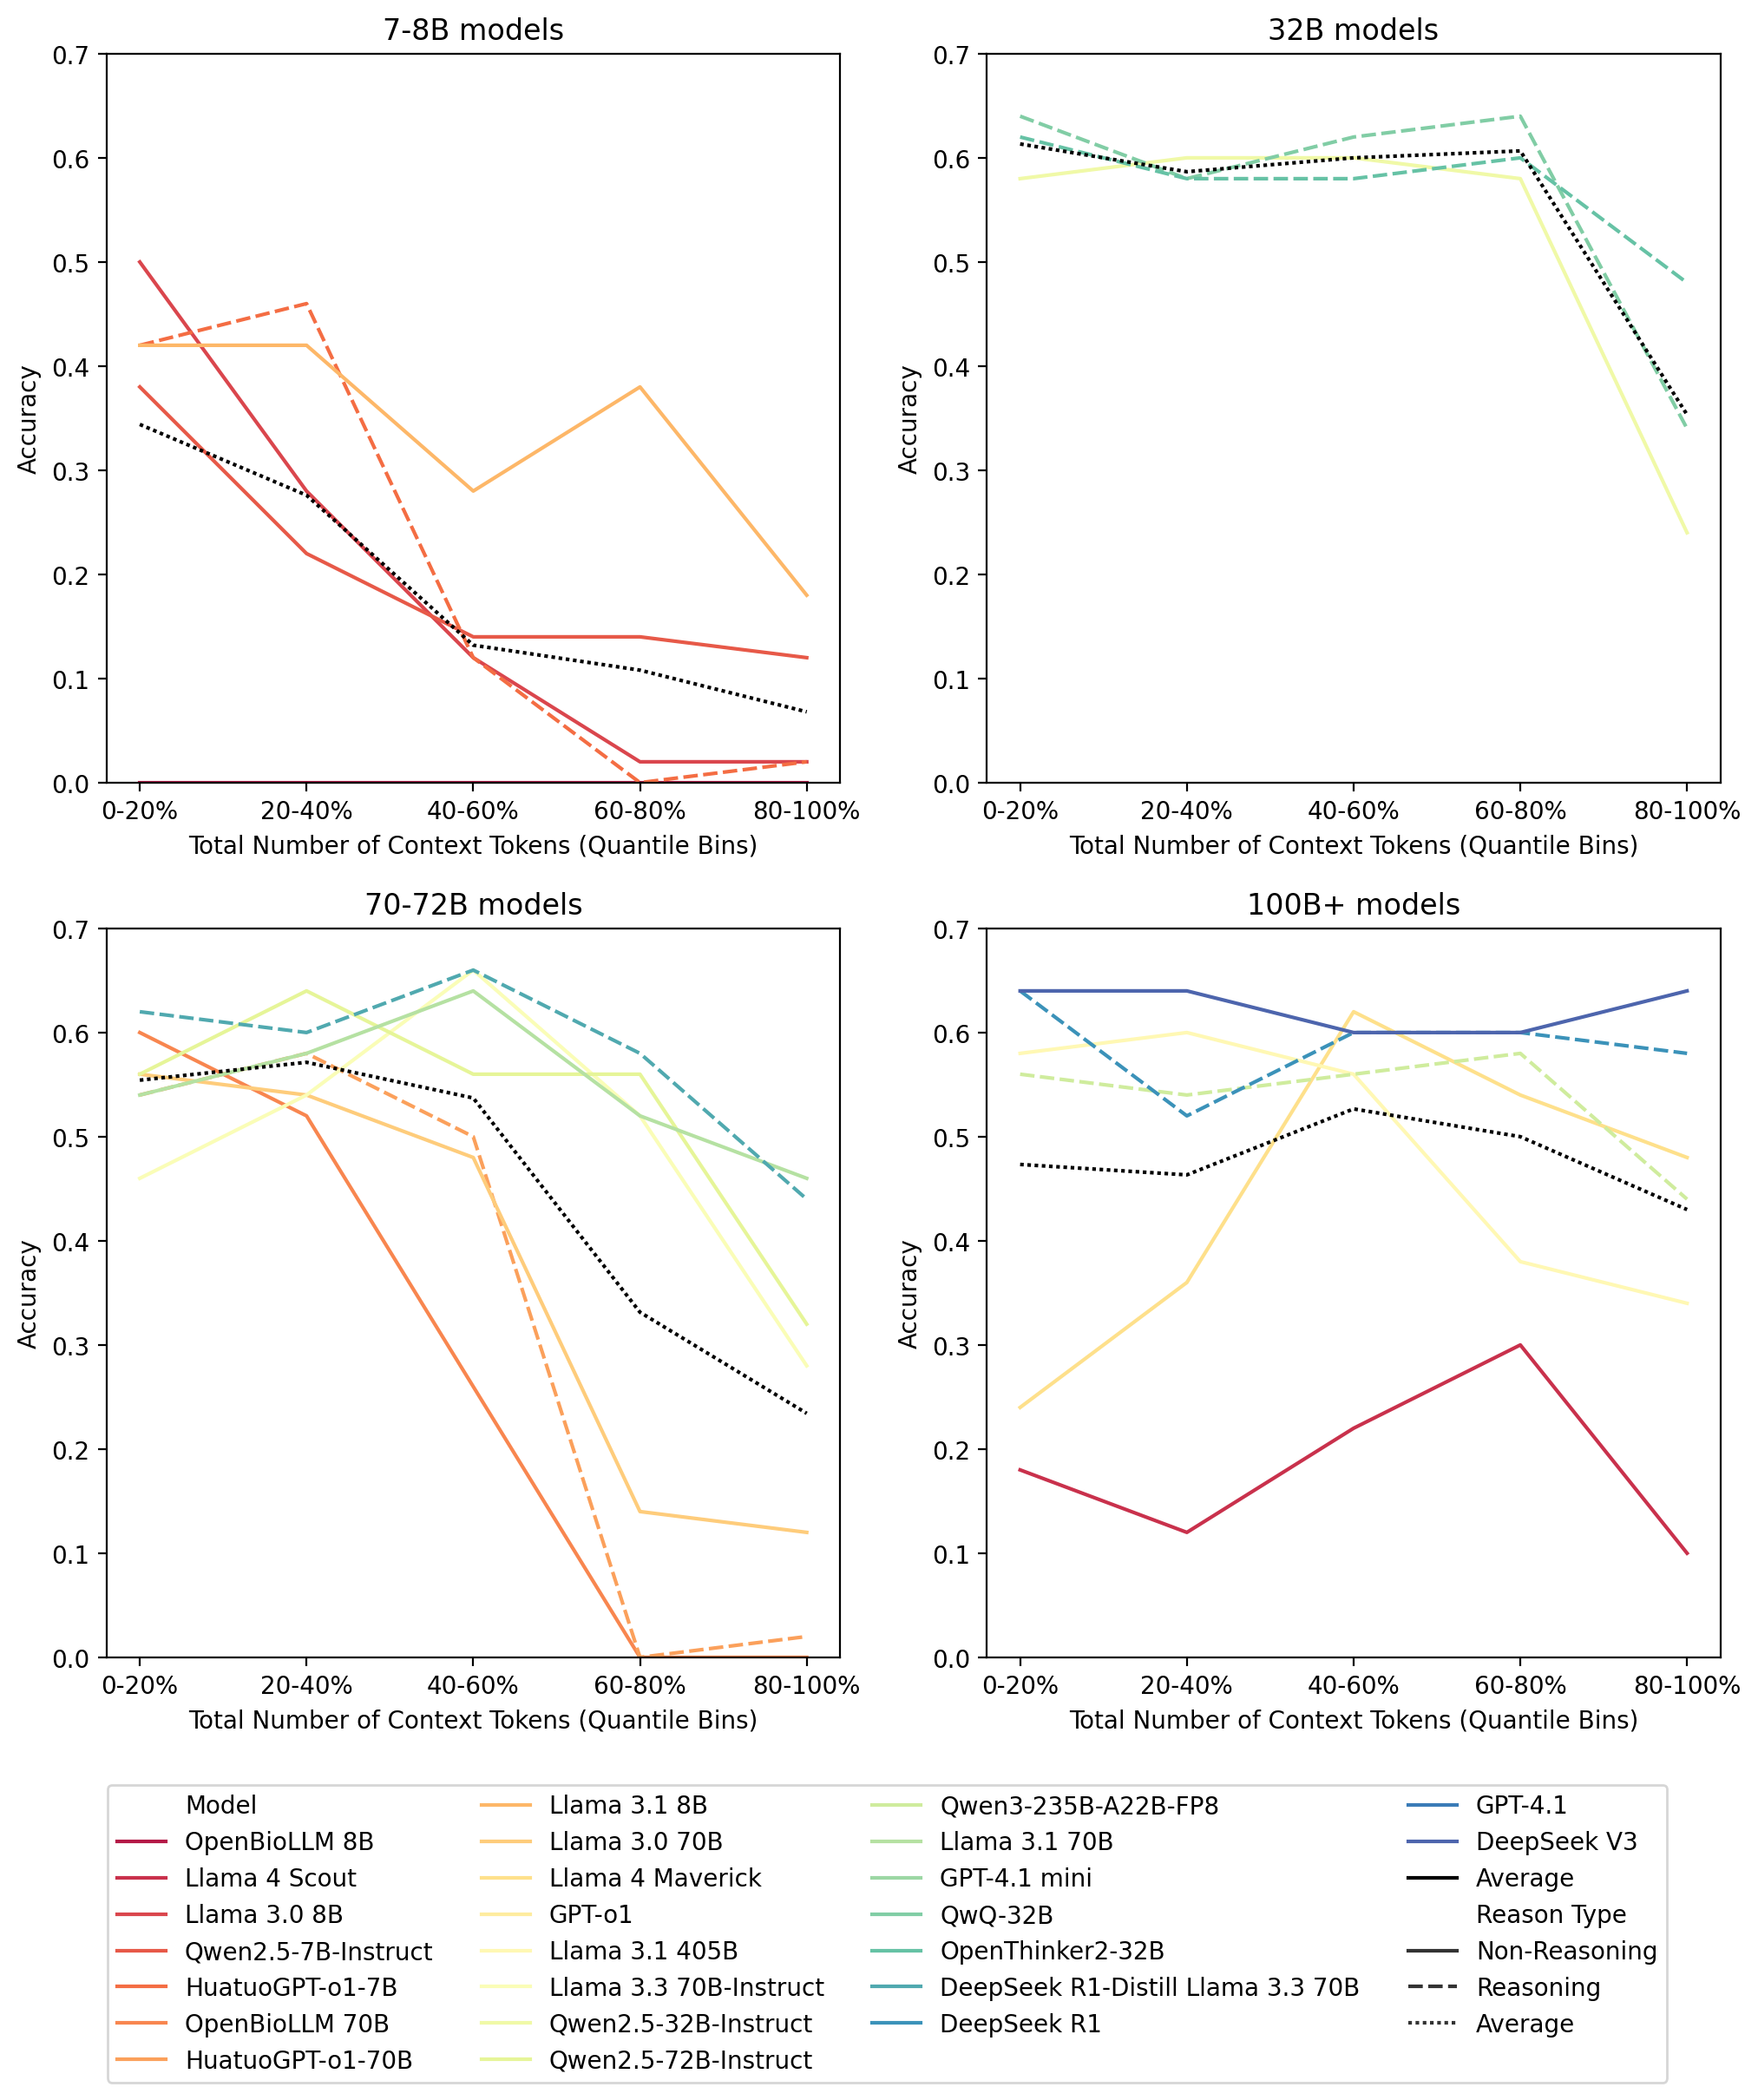

In [ ]:
model_sets = [
    (long_df['Model Size'] < 10, '7-8B'),
    ((long_df['Model Size'] > 10) & (long_df['Model Size'] < 40), '32B'),
    ((long_df['Model Size'] > 40) & (long_df['Model Size'] < 80), '70-72B'),
    ((long_df['Model Size'] > 100), '100B+'),
]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12), dpi=200)
for i, (mask, mtype) in enumerate(model_sets):
    ax = axs[i//2, i%2]
    _df = long_df[mask]
    # pal = sns.color_palette('husl', n_colors=len(_df.Model.unique()))
    colors = []
    for m in _df.Model.unique():
        ix = model_order.set_index('Model').index.get_loc(m)
        colors.append(palette[ix])
    _df_2 = _df.copy(deep=True)
    _df_2["Model"] = "Average"
    _df_2["is_medical"] = 0
    _df_2["Reason Type"] = "Average"

    catdf = pd.concat([_df, _df_2])
    avg_palette = colors + ['black']
    sns.lineplot(catdf, ax=ax, x='token_bin', y='score', hue='Model', style='Reason Type',
                errorbar=None, palette=avg_palette)
    # ax.plot(evqual_df.mean().values, label="Average", color='k', linestyle='--', linewidth='2')
    # ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3)
    ax.set_xlabel('Total Number of Context Tokens (Quantile Bins)')
    ax.legend('off')
    if i > -1:
        ax.set_ylabel('Accuracy')
    ax.set_title(f'{mtype} models')
    ax.set_ylim(0, 0.7)
    ax.legend().set_visible(False)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=4)
fig.show()

#### run stuff

In [88]:
# df_basic,_ = make_df("run-med-evidence/___res/{MODEL}_closed_barebones_fulltext.jsonl", outfiles)
# df_basic = df_basic[['Model', 'Accuracy']]
# df_expguided,_ = make_df("run-med-evidence/___res/{MODEL}_closed.jsonl", outfiles)
# df_expguided = df_expguided[['Model', 'Accuracy']]

# joint = df_basic.merge(df_expguided, on='Model', suffixes=(' (Basic)', ' (Expert Guided)'))
# joint["Diff (expert-basic)"] = joint["Accuracy (Expert Guided)"] - joint['Accuracy (Basic)']
# joint

In [27]:
outfiles = [
    # format: (model, display name, model_series, is_reasoning, model_size in B, is_medical) [-1 = do not include]
    ("deepseekR1", "DeepSeek R1", '', 1, 671, 0),
    ("deepseekV3", "DeepSeek V3", '', 0, 671, 0),
    ("gpt4_1", "GPT-4.1", 'GPT-4.1', 0, -1, 0),
    ("gpt4_1mini", "GPT-4.1 mini", 'GPT-4.1', 0, -1, 0),
    ("gpto1", "GPT-o1", '', 1, -1, 0),
    ("huatuo7b", "HuatuoGPT-o1-7B", '', 1, 6.99, 1),
    ("huatuo70b", "HuatuoGPT-o1-70B", '', 1, 69.99, 1),
    ("llama3_1_8b", "Llama 3.1 8B", 'Llama 3.1', 0, 8, 0),
    ("llama3_1_70b", "Llama 3.1 70B", 'Llama 3.1', 0, 70, 0),
    ("llama3_1_405b", "Llama 3.1 405B", 'Llama 3.1', 0, 405, 0),
    ("llama3_8b", "Llama 3.0 8B", 'Llama 3.0', 0, 8, 0),
    ("llama3_70b", "Llama 3.0 70B", 'Llama 3.0', 0, 70, 0),
    ("llama4mav", "Llama 4 Maverick", 'Llama 4', 0, 400, 0),
    ("llama4scout", "Llama 4 Scout", 'Llama 4', 0, 109, 0),
    ("llama70b_instruct", "Llama 3.3 70B-Instruct", '', 0, 70, 0),
    ("llama70b_r1distill", "Llama 3.3 70B (R1-Distill)", '', 1, 70, 0),
    ("openbiollm_8b", "OpenBioLLM 8B", '', 0, 7.99, 1),
    ("openbiollm_70b", "OpenBioLLM 70B", '', 0, 69.99, 1),
    ("openthinker2_32b", "OpenThinker2-32B", '', 1, 32, 0),
    ("qwen3_235b", "Qwen3-235B-A22B-FP8", '', 1, 235, 0),
    ("qwen7b", "Qwen2.5-7B-Instruct", 'Qwen2.5', 0, 7, 0),
    ("qwen32b", "Qwen2.5-32B-Instruct", 'Qwen2.5', 0, 32, 0),
    ("qwen72b", "Qwen2.5-72B-Instruct", 'Qwen2.5', 0, 72, 0),
    ("qwq32b", "QwQ-32B", '', 1, 32, 0),
]

analysis_sets = [
    ("basic prompts", "run-med-evidence/___res/{MODEL}_closed_barebones_fulltext.jsonl"),
    # ("expert-guided", "run-med-evidence/___res/{MODEL}_closed.jsonl")
]
basepath = analysis_sets[0][1]
long_df, palette, model_order, catdf, avg_palette = make_long_df(basepath, outfiles)

/tmp/clcp/ipykernel_1544234/3489808636.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  long_df = pd.concat(dfs).sort_values(['Accuracy', 'Model'])


In [77]:
def main_acc_plot(ax, df):
    sns.barplot(df, x='score', y='Model', hue='Model', errorbar=('ci', 95), n_boot=1000, palette=palette, ax=ax,
                err_kws=dict(linewidth=1, color='#000000'), capsize=0.3)

    for i, bar in enumerate(ax.patches):
        if model_order.iloc[i].is_medical:
            bar.set_edgecolor('black')
            bar.set_linewidth(2)
        if model_order.iloc[i]['Reason Type'] == 'Reasoning':
            bar.set_hatch('//')
    legend_elements = [
        Patch(facecolor='grey', hatch='//', label=f'Reasoning'),
        Patch(facecolor='grey', hatch='', label=f'Non-Reasoning'),
        Patch(facecolor='grey', edgecolor='black', linewidth=2, hatch='', label=f'Medically Finetuned')
    ]
    # ax.set_xlim(0, 1)
    ax.set_xlabel('Overall Accuracy')
    ax.set_ylabel('')

    # Add the legend
    ax.legend(handles=legend_elements)

def avg_recall_plot(ax, df):
    avgs = df[df.Model=='Average']
    sns.barplot(avgs, x='correct_answer', y='score', ax=ax, color='lightgrey', linewidth=1,
                order=['uncertain effect', 'no difference', 'insufficient data', 'higher', 'lower'],
                errorbar=('ci', 95), err_kws=dict(linewidth=1.5, color='#000000'), capsize=0.3)
    ax.set_xlabel('Treatment Outcome Effect')
    ax.set_xticklabels(['Uncertain\nEffect', 'No Difference', 'Insufficient\nData', 'higher', 'lower'], fontsize=8, rotation=30)
    ax.set_ylabel('Average Recall')

/tmp/clcp/ipykernel_1457449/259615261.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Uncertain\nEffect', 'No Difference', 'Insufficient\nData', 'higher', 'lower'], fontsize=8, rotation=30)


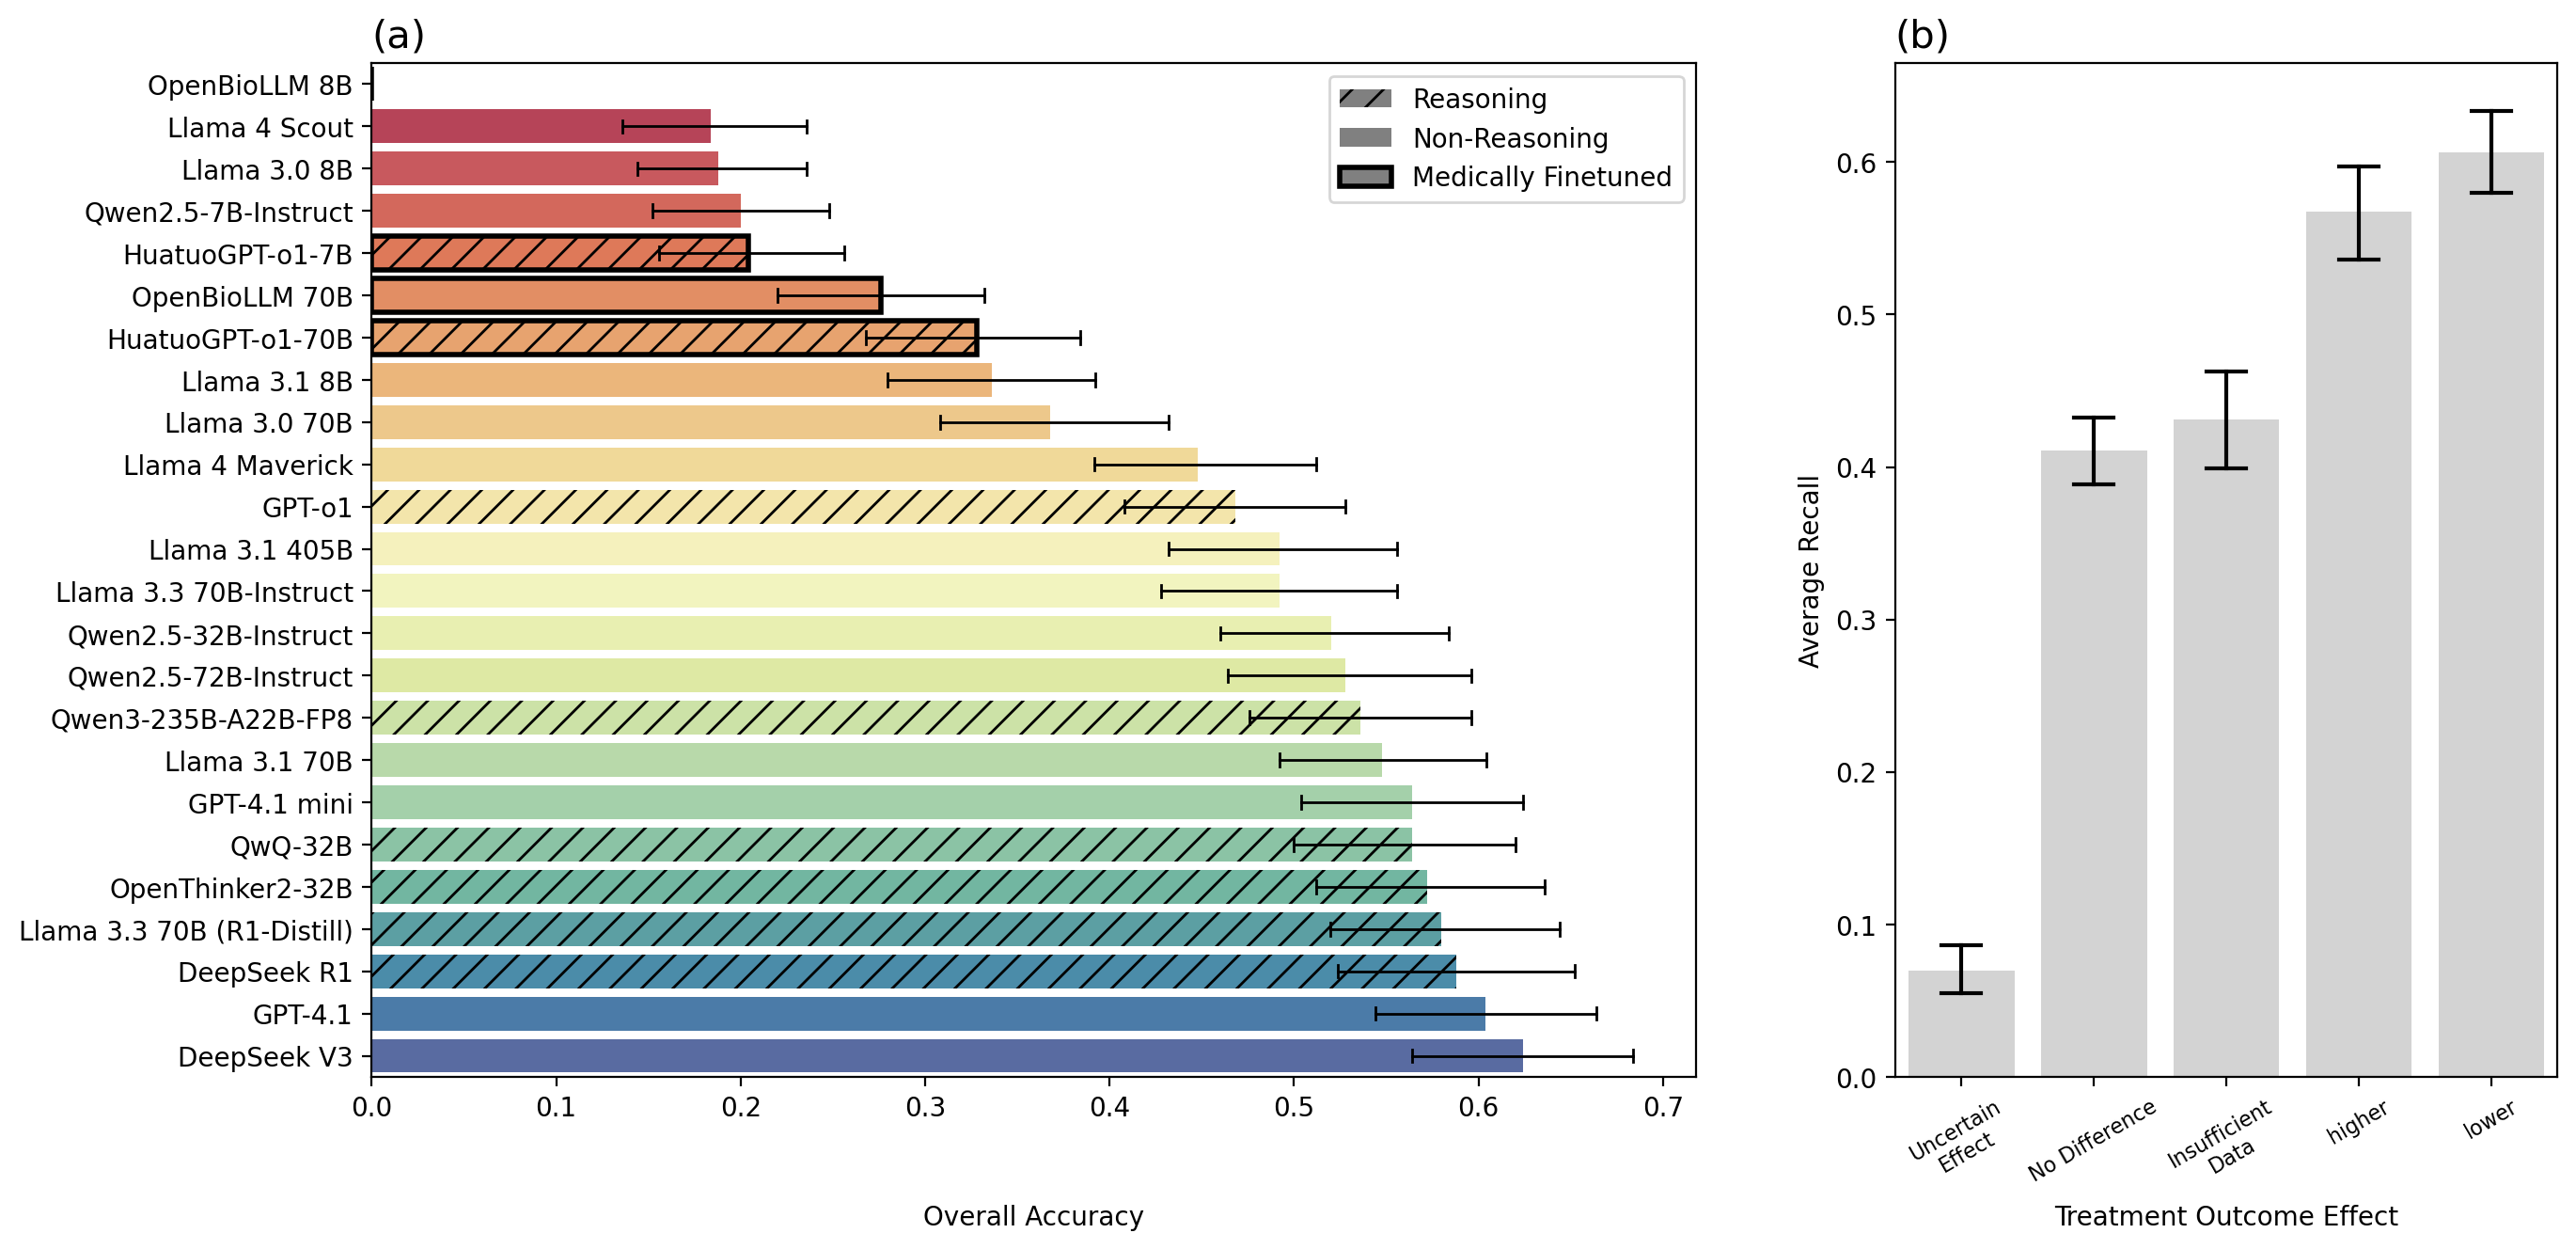

In [81]:
fig, axs = plt.subplots(ncols=2, figsize=(15,7), dpi=200, width_ratios=[2,1])
main_acc_plot(axs[0], long_df)
avg_recall_plot(axs[1], catdf)
axs[0].set_title('(a)', loc='left', fontsize=15)
axs[1].set_title('(b)', loc='left', fontsize=15)
fig.align_xlabels()
fig.show()

/tmp/clcp/ipykernel_1544234/2981848944.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['srt_evidence_quality'] = pd.Categorical(df['evidence_quality'], categories=EVIDENCE_QUALITIES, ordered=True)
/tmp/clcp/ipykernel_1544234/2981848944.py:10: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(df, x='srt_evidence_quality', y='score', hue='Model', style='Reason Type', palette=pal,


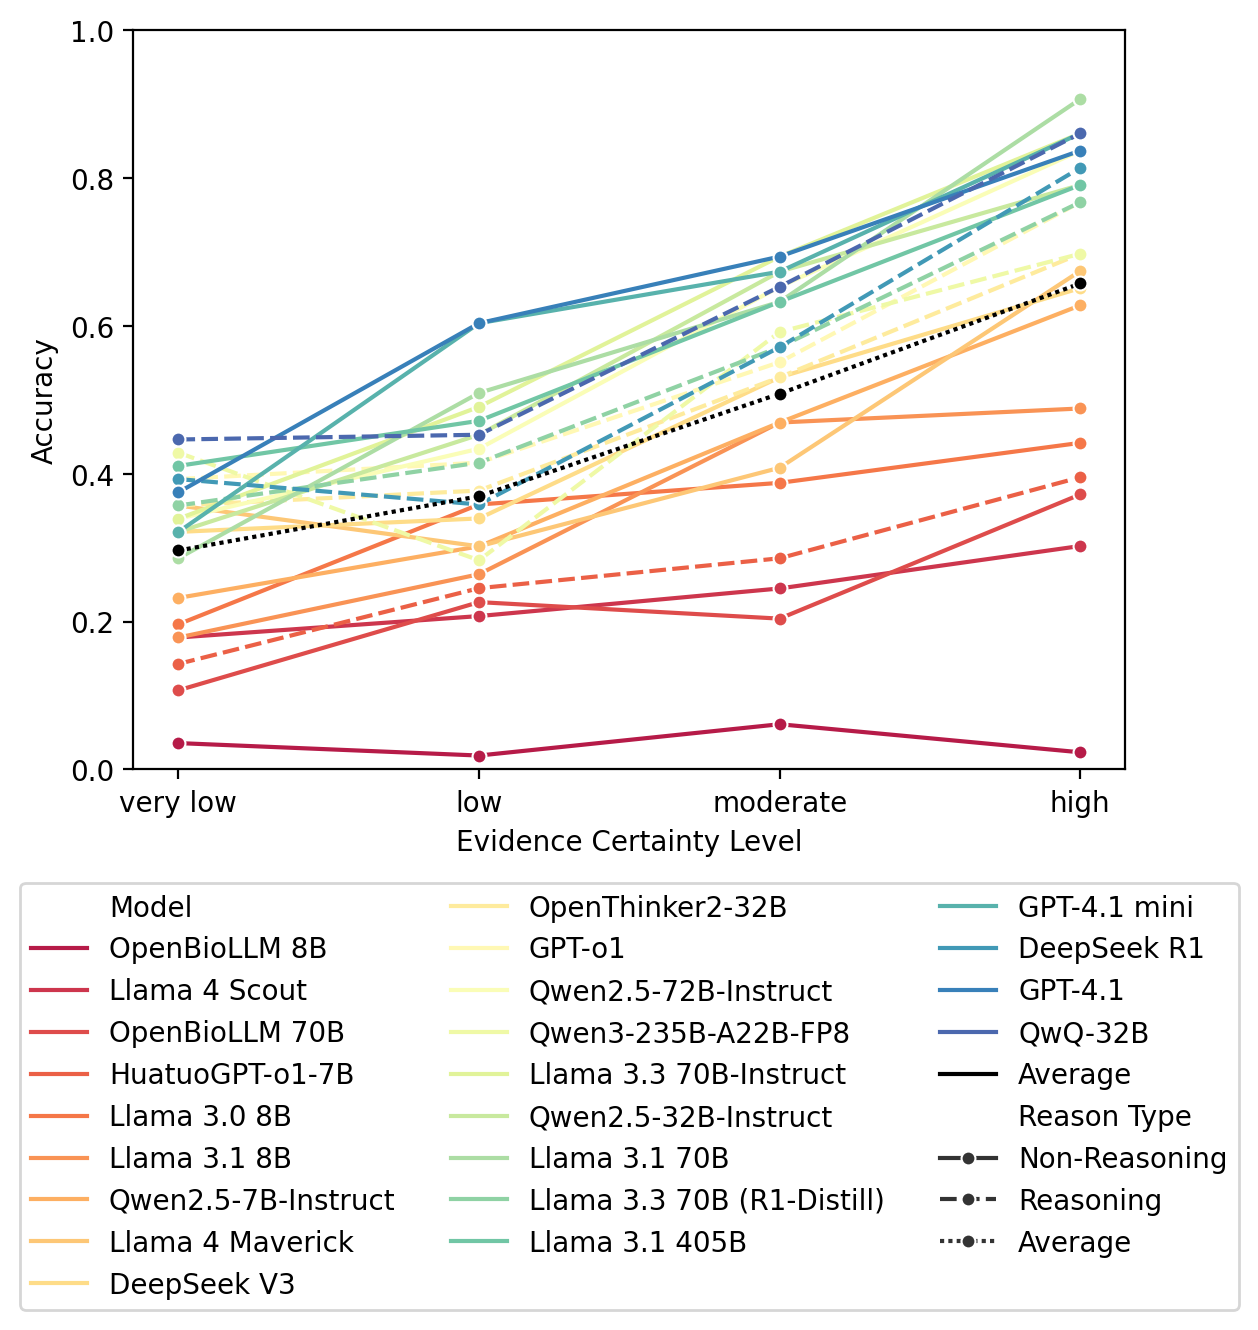

In [25]:
fig, ax = plt.subplots(dpi=200)
evidence_quality_plot(ax, catdf, pal=avg_palette)

/tmp/clcp/ipykernel_1544234/2981848944.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['srt_evidence_quality'] = pd.Categorical(df['evidence_quality'], categories=EVIDENCE_QUALITIES, ordered=True)
/tmp/clcp/ipykernel_1544234/2981848944.py:10: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(df, x='srt_evidence_quality', y='score', hue='Model', style='Reason Type', palette=pal,
/tmp/clcp/ipykernel_1544234/1171577743.py:13: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(df, x='srt_sla_bin', y='score', hue='Model', style='Reason Type', palette=pal,


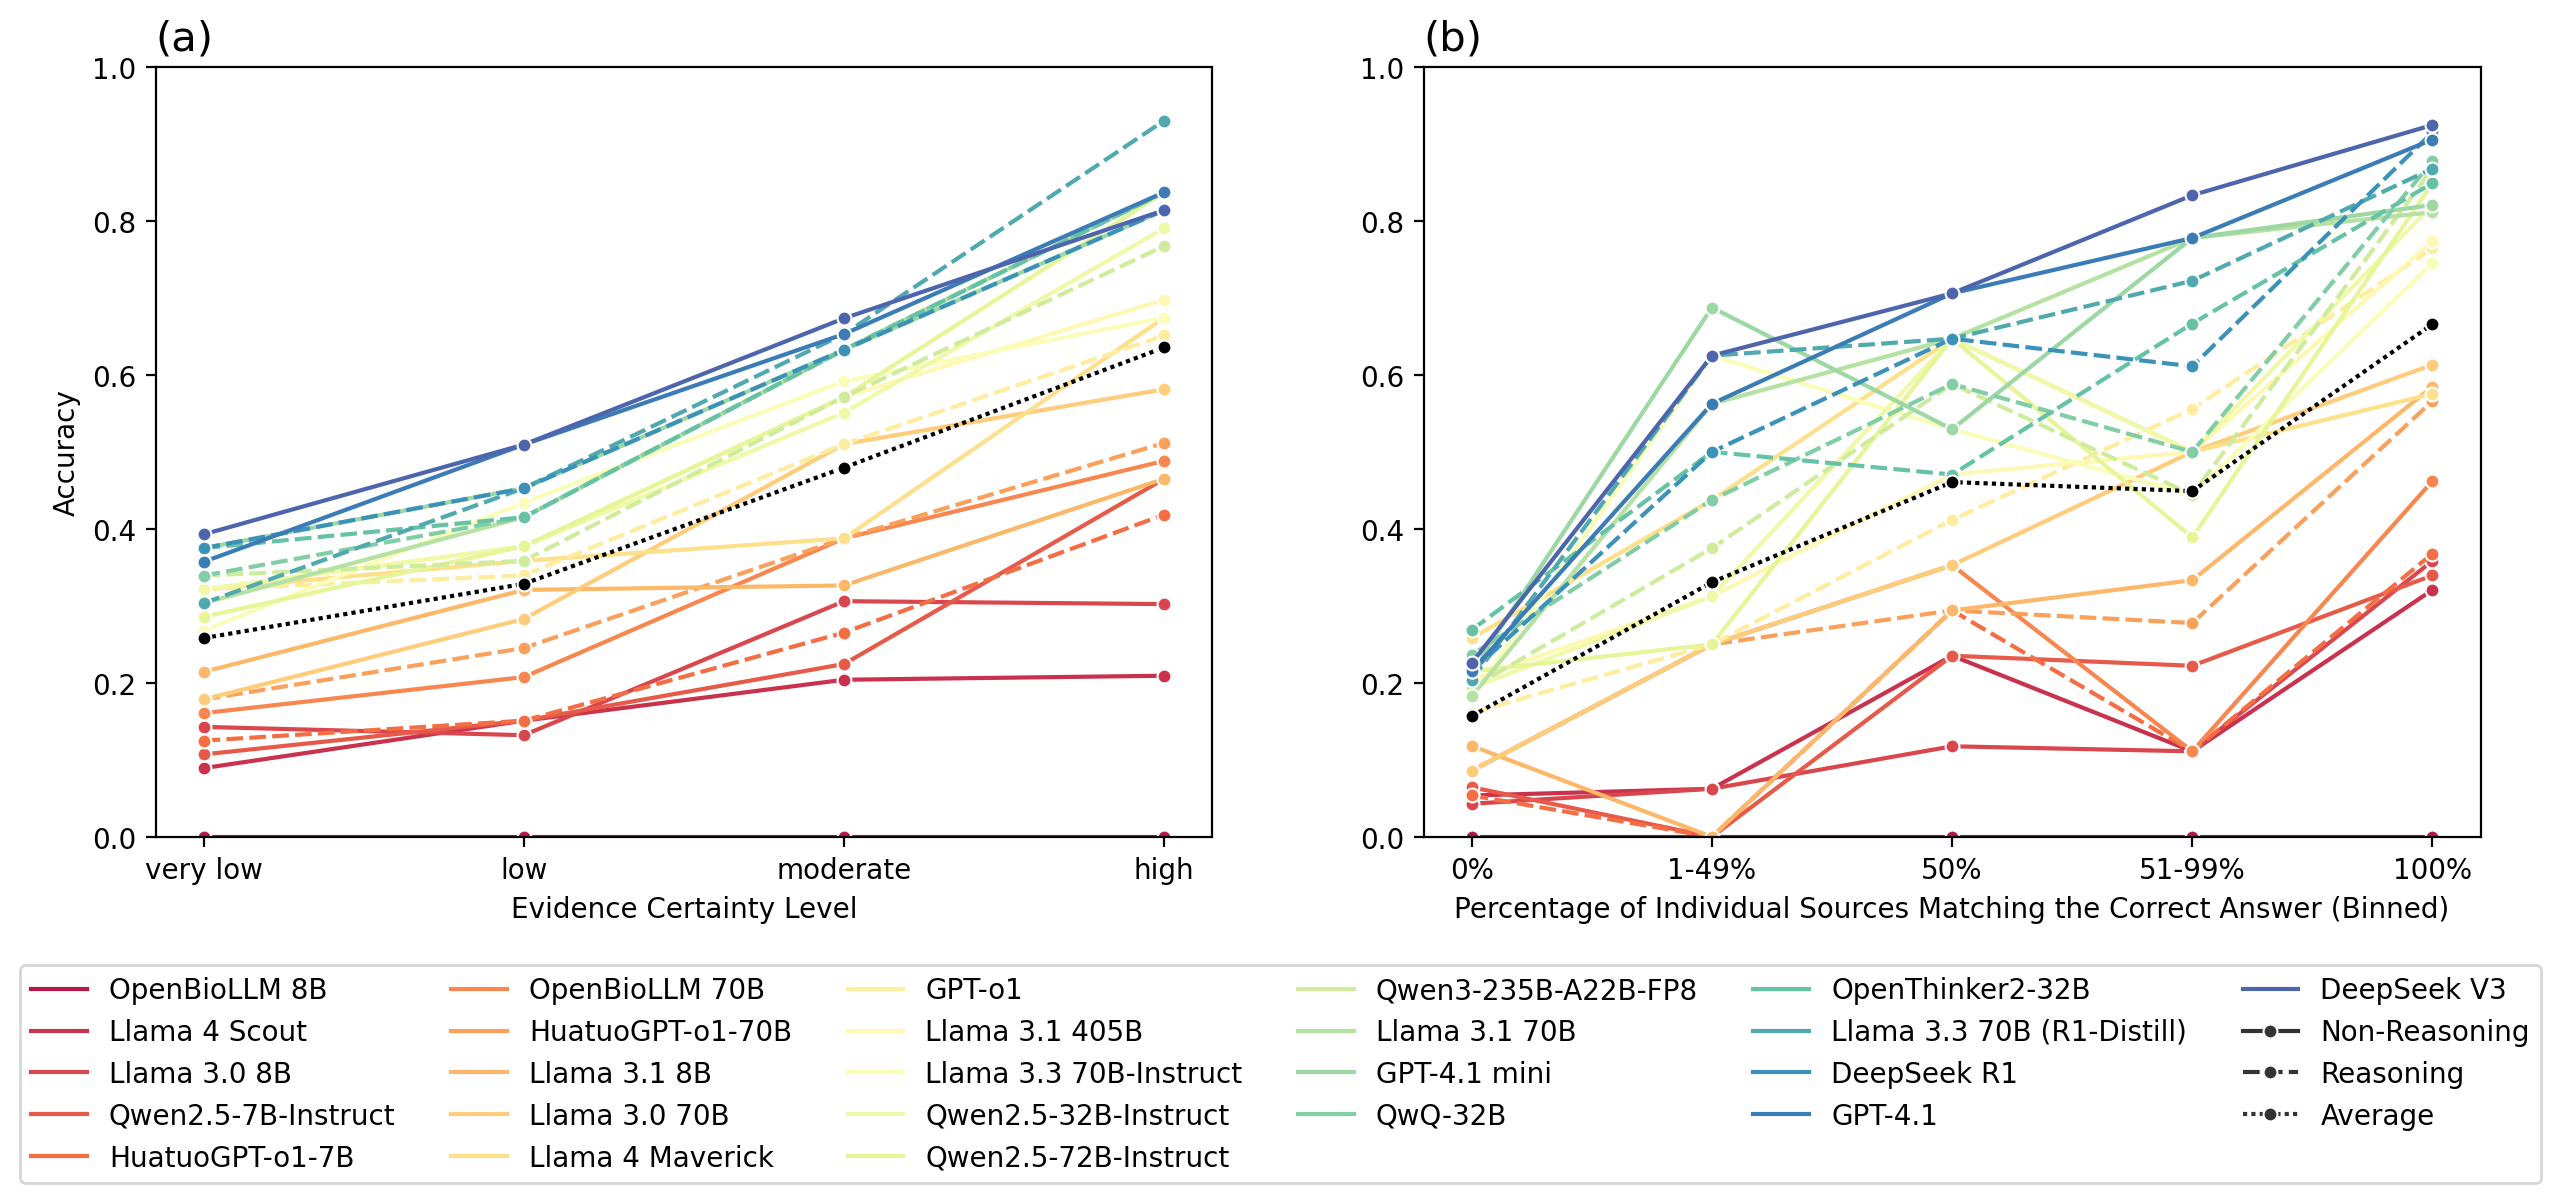

In [37]:
MSIZE = 10
# df, pal = make_df(basepath, outfiles)
fig, ax = plt.subplots(ncols=2, figsize=(15,5), dpi=200)
evidence_quality_plot(ax[0], catdf, pal=avg_palette)
percent_source_agreement_plot(ax[1], catdf, pal=avg_palette)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend().set_visible(False)
ax[0].set_xlabel("Evidence Certainty Level")
ax[0].set_title('(a)', loc='left', fontsize=15)
ax[1].set_xlabel("Percentage of Individual Sources Matching the Correct Answer (Binned)")
ax[1].set_ylabel("")
ax[1].set_title('(b)', loc='left', fontsize=15)
ax[1].legend().set_visible(False)
fig.legend(handles[1:-5]+handles[-3:], labels[1:-5]+labels[-3:], loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=6)
fig.show()
fig.savefig('figs/certainty_and_sla.pdf')

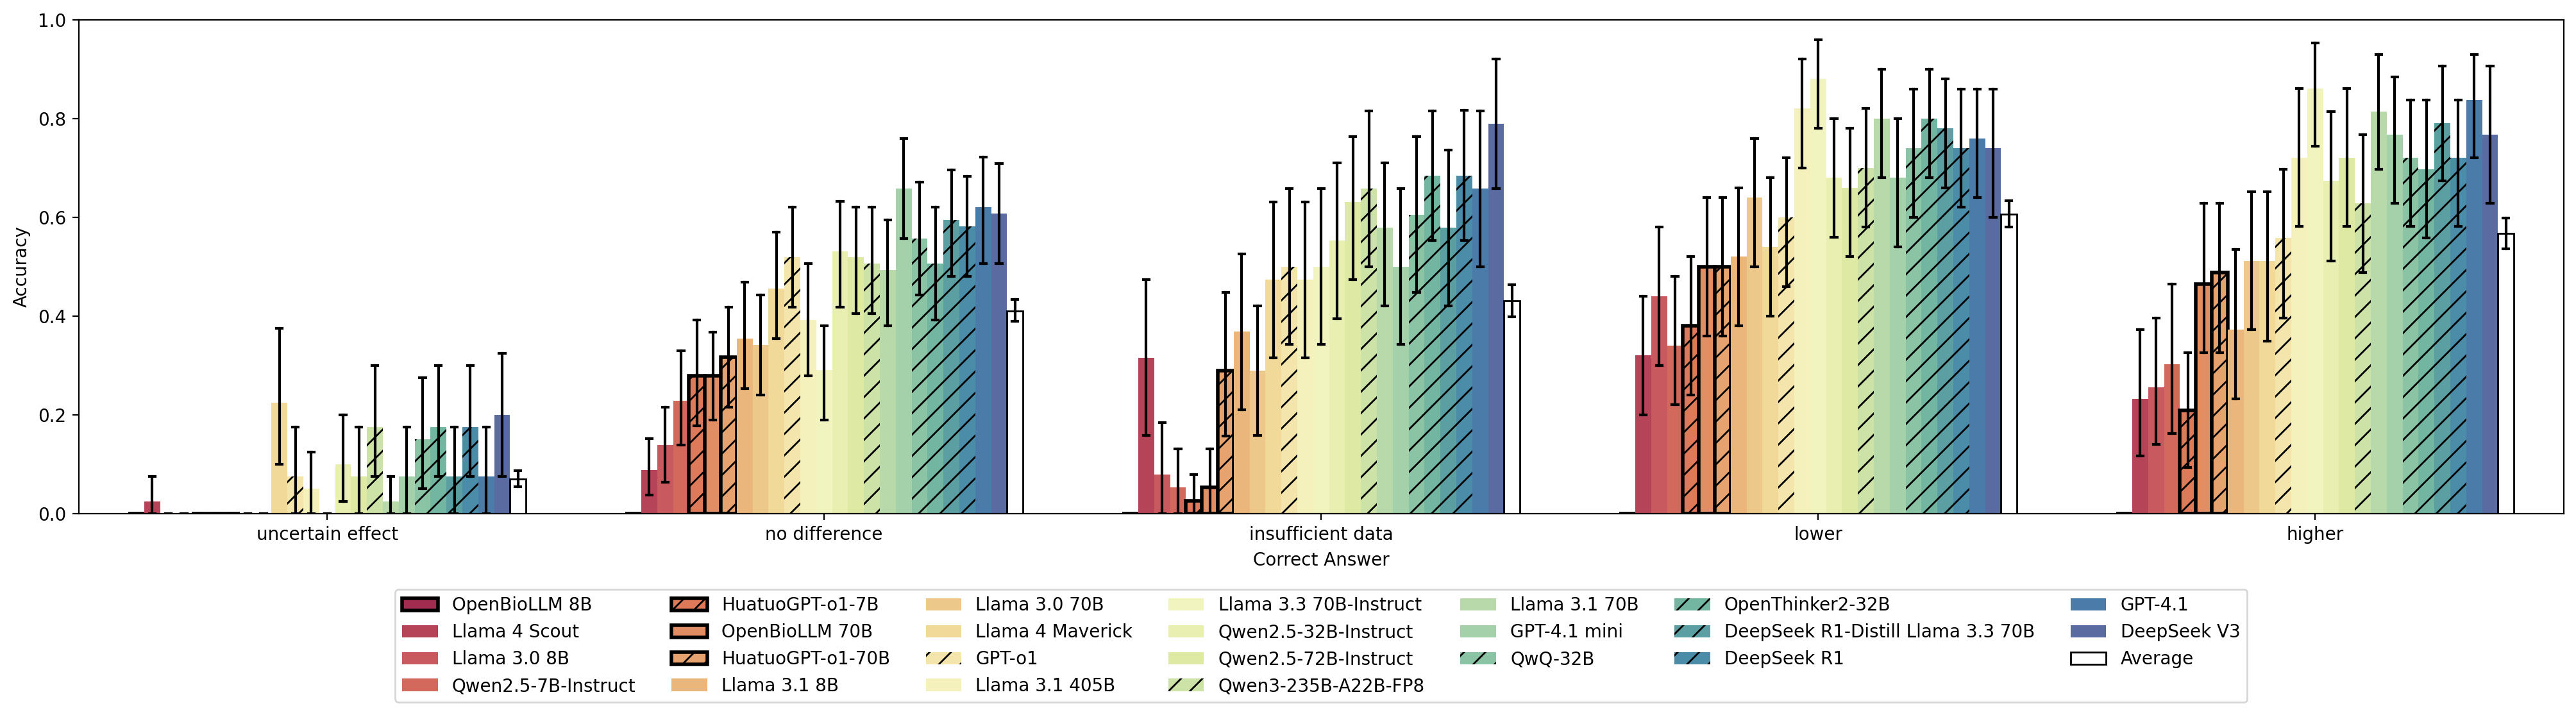

In [ ]:
### APPENDIX VERSION OF PER-CLASS PERFORMANCE
fig, ax = plt.subplots(figsize=(25,5), dpi=200)
# AVG_COLOR = 'white'
# long_df_2 = long_df.copy(deep=True)
# long_df_2["Model"] = "Average"
# long_df_2["is_medical"] = 0
# long_df_2["Reason Type"] = "Non-Reasoning"

# catdf = pd.concat([long_df, long_df_2])
mypal = list(palette) + ['white']

sns.barplot(catdf, x='correct_answer', y='score', hue='Model', palette=mypal, ax=ax,
            order=['uncertain effect', 'no difference', 'insufficient data', 'lower', 'higher'],
            errorbar=('ci', 95), err_kws=dict(linewidth=1.5, color='#000000'), capsize=0.3)

for i, bars in enumerate(ax.containers):
    # Set a different hatch for each group of bars
    for bar in bars:
        if i >= len(model_order):
            bar.set_edgecolor('black')
            bar.set_linewidth(1)
            continue
        if model_order.iloc[i].is_medical:
            bar.set_edgecolor('black')
            bar.set_linewidth(2)
        if model_order.iloc[i]['Reason Type'] == 'Reasoning':
            bar.set_hatch('//')

handles, labels = ax.get_legend_handles_labels()
# Modify the patch properties
for i, handle in enumerate(handles):
    if i >= len(model_order):
        handle.set_edgecolor('black')
        handle.set_linewidth(1)
        continue
    if model_order.iloc[i].is_medical:
        handle.set_edgecolor('black')
        handle.set_linewidth(2)
    if model_order.iloc[i]['Reason Type'] == 'Reasoning':
        handle.set_hatch('//')
ax.set_ylim(0, 1)
ax.set_xlabel('Correct Answer')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=7)
fig.show()

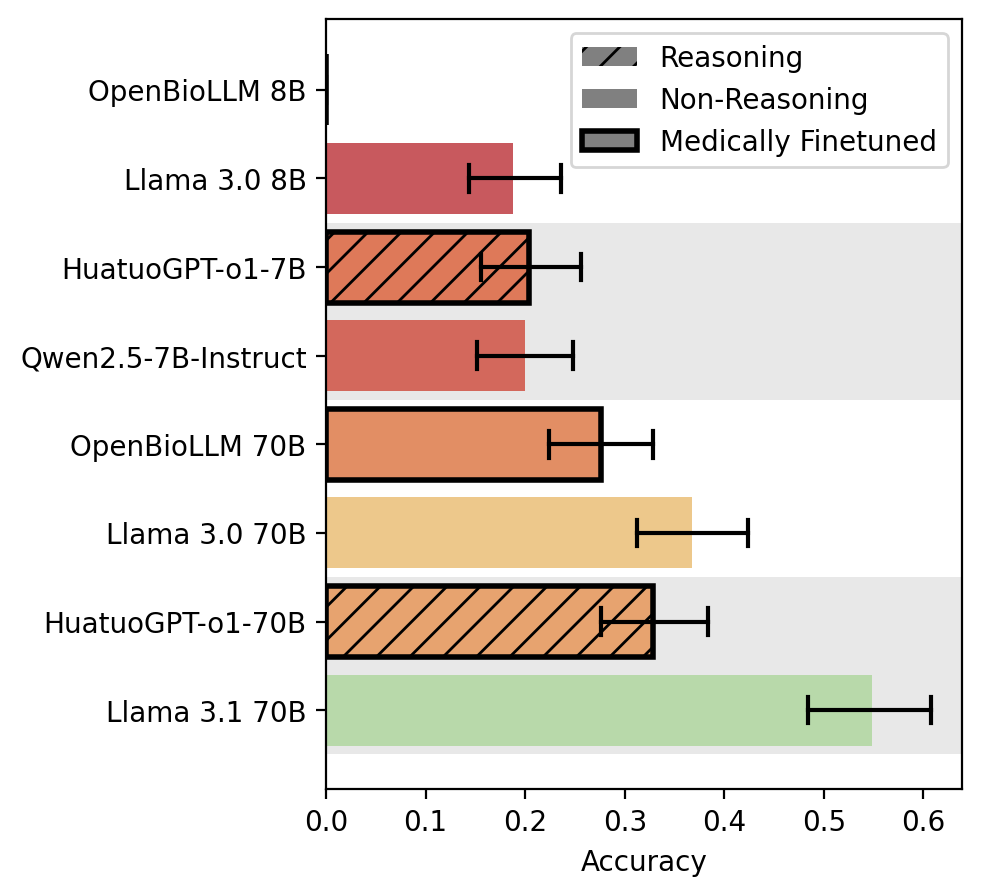

In [31]:
pal = palette
fig, ax = plt.subplots(dpi=200, figsize=(4.1,5))
pairs = [
    "OpenBioLLM 8B", "Llama 3.0 8B",
    "HuatuoGPT-o1-7B", "Qwen2.5-7B-Instruct",
    "OpenBioLLM 70B", "Llama 3.0 70B",
    "HuatuoGPT-o1-70B", "Llama 3.1 70B"
]
medpairdf = long_df.set_index('Model').loc[pairs, :].reset_index(names='Model')
medmodelorder = model_order.set_index('Model').loc[pairs,:].reset_index()
colors = []
for p in pairs:
    ix = model_order.set_index('Model').index.get_loc(p)
    colors.append(pal[ix])
sns.barplot(medpairdf, y='Model', x='score', hue='Model', palette=colors, legend=False, orient='h', ax=ax,
            errorbar=('ci', 95), err_kws=dict(linewidth=1.5, color='#000000'), capsize=0.3)
for i, bar in enumerate(ax.patches[-len(medpairdf):]):
    if medmodelorder.iloc[i].is_medical:
        bar.set_edgecolor('black')
        bar.set_linewidth(2)
    if medmodelorder.iloc[i]['Reason Type'] == 'Reasoning':
        bar.set_hatch('//')
for i in range(len(pairs)//2):
    if i % 2 == 1:
        ax.axhspan(2*i-0.5, 2*i+1.5, facecolor='lightgrey', alpha=0.5, edgecolor=None, zorder=0)
legend_elements = [
    Patch(facecolor='grey', hatch='//', label=f'Reasoning'),
    Patch(facecolor='grey', hatch='', label=f'Non-Reasoning'),
    Patch(facecolor='grey', edgecolor='black', linewidth=2, hatch='', label=f'Medically Finetuned')
]
ax.legend(handles=legend_elements)
# ax.set_xlim(0,1)
ax.set_xlabel('Accuracy')
ax.set_ylabel('')
fig.show()

In [ ]:
basepath = analysis_sets[0][1]
all_mats = []
for (modelname, display_name, model_series, is_reasoning, model_size, is_medical) in outfiles:
    filepath = basepath.format(MODEL=modelname)
    eval_df = grade(filepath)
    acc = eval_df.score.mean()
    if acc < 0.4:
        continue
    mat = conf_mat(eval_df)
    all_mats.append(mat)
    # fig, ax = plt.subplots()
    # sns.heatmap(mat, annot=True, ax=ax)
    # ax.set_xlabel('Correct')
    # ax.set_ylabel('Predicted')
    # ax.set_title(modelname)
    # fig.show()

avg_mat = functools.reduce(lambda x, y: x.add(y, fill_value=0), all_mats)  / len(all_mats)
fig, ax = plt.subplots(dpi=200)
sns.heatmap(avg_mat, annot=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Correct')
# ax.set_title("Average")
fig.show()

Text(101.44444444444443, 0.5, 'Question')

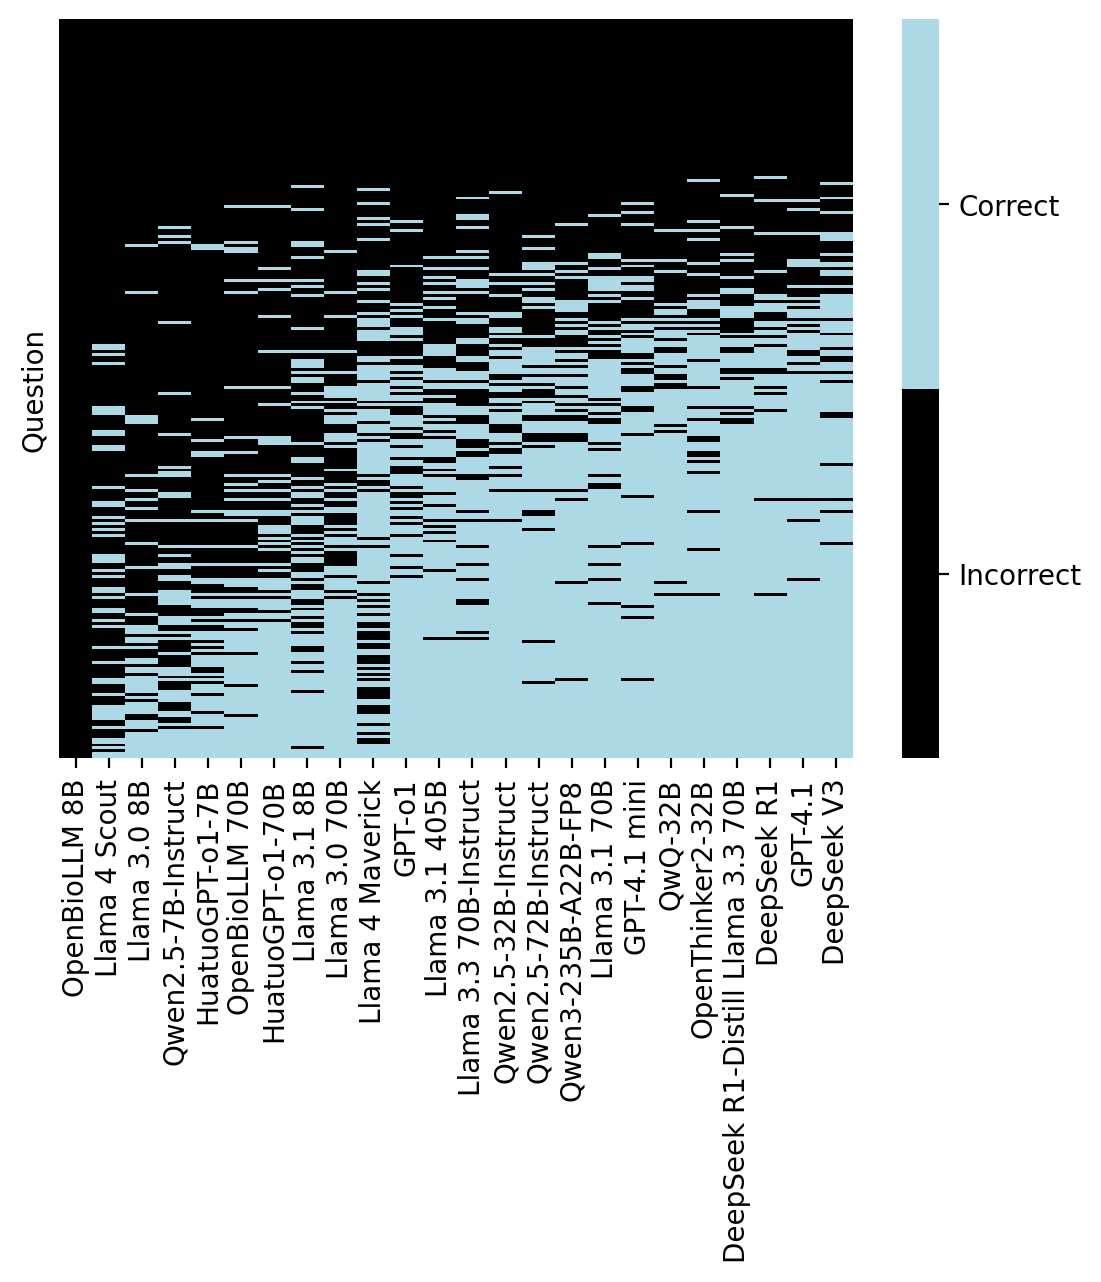

In [45]:
from collections import Counter
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter
joint_key = "score"
joint_basecols = ["question_id"]
joint_df = pd.DataFrame()
cmap = colors.ListedColormap(['black', 'lightblue'])
for (modelname, display_name, model_series, is_reasoning, model_size, is_medical) in outfiles:
    filepath = basepath.format(MODEL=modelname)
    eval_df = grade(filepath)
    if joint_df.empty:
        joint_df = eval_df[joint_basecols]
    _subset = eval_df[["question_id", joint_key]].rename(columns={joint_key: display_name})
    joint_df = joint_df.merge(_subset, how='outer', on=["question_id"])
joint_df['sum'] = joint_df.iloc[:, 1:].sum(axis=1)
joint_df = joint_df.sort_values('sum').reset_index(drop=True)
fig, ax = plt.subplots(dpi=200)
tickformat = lambda x, _: 'Incorrect' if x < 0.5 else 'Correct'
sns.heatmap(joint_df.loc[:, model_order.Model.values], cmap=cmap, ax=ax, cbar_kws={'ticks': [0.25, .75], 'format': FuncFormatter(tickformat)})
ax.set_yticks([])
ax.set_ylabel('Question')
# all_wrong_mask = ~joint_df.set_index('question_id').any(axis=1).values
# Counter(eval_df[all_wrong_mask].correct_answer.values)

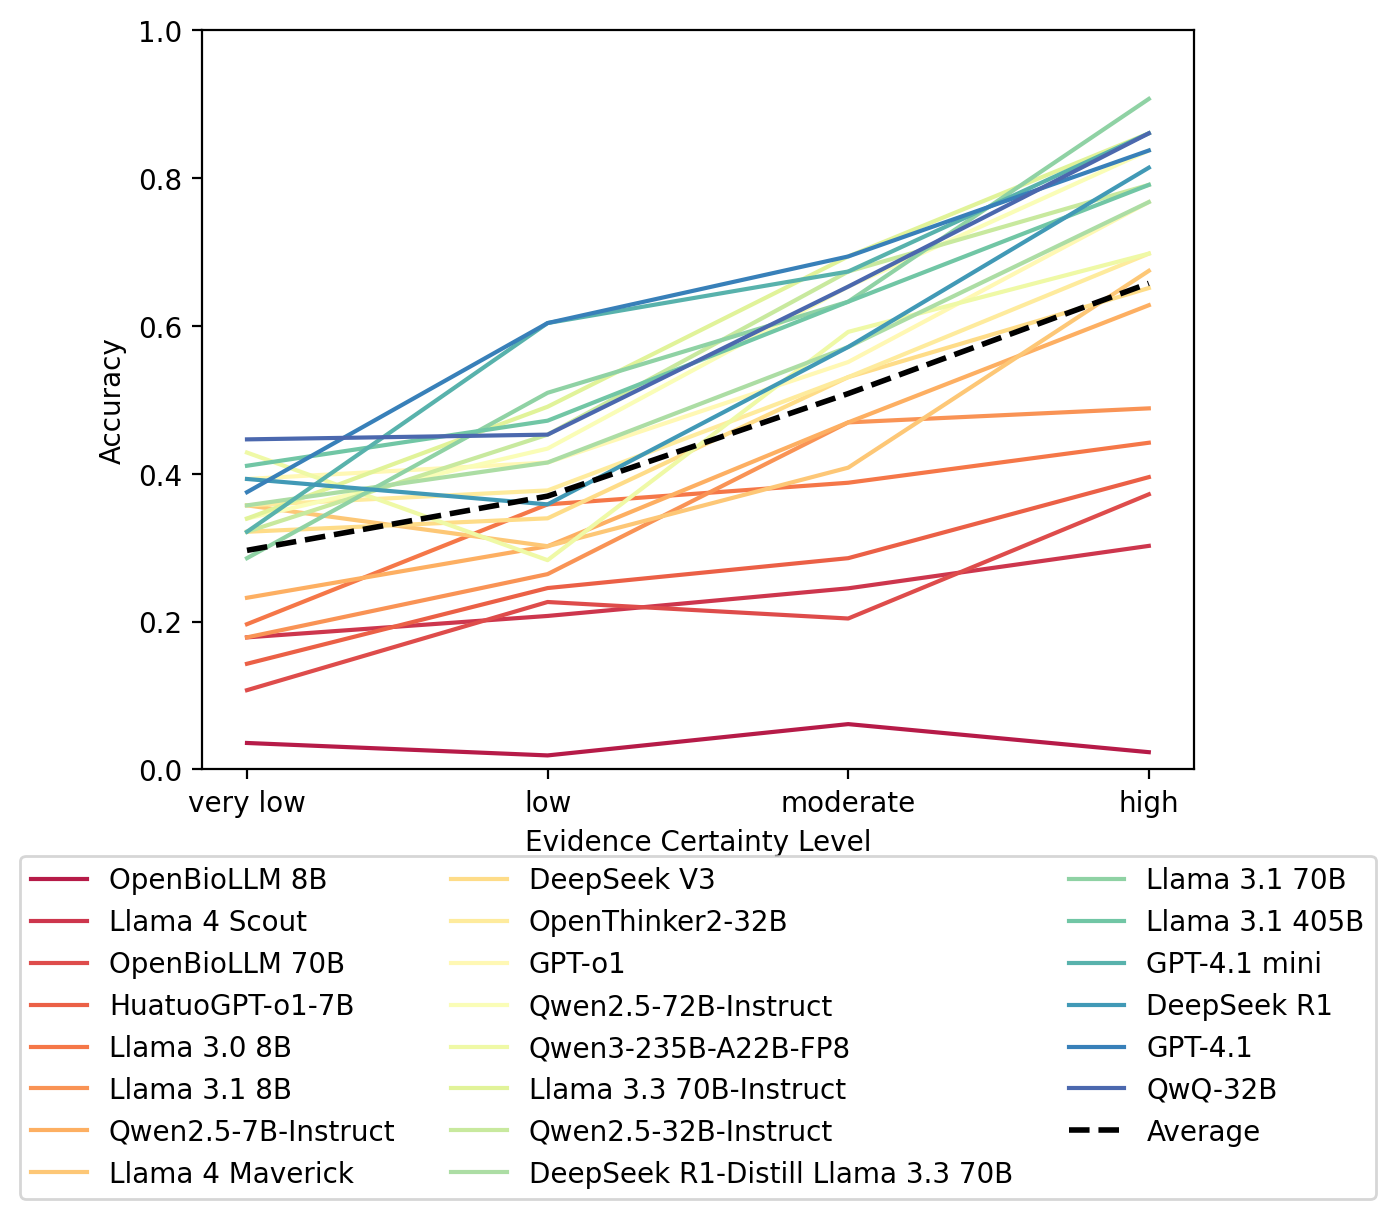

In [202]:
plot_funcs = [
    evidence_quality_plot,
    # percent_source_agreement_plot,
    # num_sources_plot,
    # model_size_plot,
    # percent_valid_plot,
]
df, pal = make_df(basepath, outfiles)
for plot_func in plot_funcs:
    fig, ax = plt.subplots(dpi=200)
    plot_func(ax, df, pal=pal)
    # fig.suptitle(f"{plotname} - {name}")
    fig.show()

### random stats stuff

In [110]:
model_order

,Model,is_medical,Reason Type
0,OpenBioLLM 8B,1,Non-Reasoning
1,Llama 4 Scout,0,Non-Reasoning
2,Llama 3.0 8B,0,Non-Reasoning
3,Qwen2.5-7B-Instruct,0,Non-Reasoning
4,HuatuoGPT-o1-7B,1,Reasoning
5,OpenBioLLM 70B,1,Non-Reasoning
6,HuatuoGPT-o1-70B,1,Reasoning
7,Llama 3.1 8B,0,Non-Reasoning
8,Llama 3.0 70B,0,Non-Reasoning
9,Llama 4 Maverick,0,Non-Reasoning


In [109]:
np.quantile(setupdf.context_tokens.values, 1)

np.int64(61875)

In [321]:
grade(basepath.format(MODEL='deepseekV3')).groupby('sla_bin').agg({'score':'mean'})

,score
sla_bin,
0%,0.225806
1-49%,0.625000
100%,0.924528
50%,0.705882
51-99%,0.833333


In [ ]:
dfs = []

model_scores = {}
basepath = "run-med-evidence/___res/{MODEL}_closed_barebones_fulltext.jsonl"
for (modelname, display_name, model_series, is_reasoning, model_size, is_medical) in outfiles:
    filepath = basepath.format(MODEL=modelname)
    eval_df = grade(filepath)
    model_scores[display_name] = eval_df.score.astype(int).tolist()
scoredf = pd.DataFrame(model_scores)
scoredf.to_csv('___tmp/model_raw_scores.csv')

    

In [101]:
import scipy.stats

rng = np.random.default_rng(seed=0)
def compute_ci(a):
    M = 1000
    N = len(a)
    p_samples = rng.choice(a, size=(M, N), replace=True).mean(axis=1)
    iv = scipy.stats.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=scipy.stats.sem(a))
    return iv # InterVal
    

data = []
CLASS = 'no difference'
for (modelname, display_name, model_series, is_reasoning, model_size, is_medical) in outfiles:
    filepath = basepath.format(MODEL=modelname)
    eval_df = grade(filepath)
    eval_df = eval_df[eval_df.correct_answer == CLASS]
    scores = eval_df.score.values
    low, high = compute_ci(scores)
    data.append({
        'Model': display_name,
        'Accuracy': scores.mean(),
        'Lower CI': low,
        'Upper CI': high
    })
pd.DataFrame(data).set_index('Model').loc[model_order.Model.values,:].to_csv('___tmp/CIs.csv')

/pasteur/u/clcp/micromamba/envs/medev2/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/pasteur/u/clcp/micromamba/envs/medev2/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
